## Import 

### pytorch

In [1]:
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn.functional as F
from functools import reduce
from operator import add, itemgetter
import torch
import torch.nn as nn
from torch.nn import (Conv2d, BatchNorm2d, MaxPool2d, AvgPool2d, ReLU, BatchNorm1d, Linear, CrossEntropyLoss,ConstantPad2d)
from torch.nn import Module
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset

import torch
from torch._six import string_classes, int_classes

from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn


import torchvision.utils as vutils
from PIL import Image


### Useful Francesco's code

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import math

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, BatchNormalization
#from keras.layers import Conv2D, MaxPooling2D, concatenate, Input
#from keras.losses import mean_squared_error
#from keras import backend as K
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
#from keras.models import Model
#from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator


import os
import subprocess
import numpy as np

import sys

#sys.path.append('spinalcordtoolbox/scripts/')
#sys.path.append('/home/fperdigon_local/spinalcordtoolbox/scripts/')
#from spinalcordtoolbox.image import Image
sys.path.insert(0, '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/')
print(sys.path)
import spinalcordtoolbox.image as Image

from skimage.morphology import square
from skimage.morphology import dilation
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import time
import pickle

size_val = 512
testing_image =[]

['/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python37.zip', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/lib-dynload', '', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/IPython/extensions', '/home/GRAMES.POLYMTL.CA/luroub/.ipython']


## code from francesco to load the data into an array

In [3]:
# !/usr/bin/env python
#
# Prepare an homogeneous Dataset for training
# This code contains useful functions to create
# a dataset from the nifti images and labels
#
# author: Francisco Perdigon Romero
# Neuropoly



Poly_DataSet_path = '../Database/PolyDatabase_2/'
labels_orginal_fname = 'labels_disc_all_posterior.nii.gz'
labels_resampled_fname = 'labels_disc_all_posterior_r.nii.gz'
labels_dilated_fname = 'labels_disc_all_posterior_dilated.nii.gz'
sagittal_flatten_fname = 'flatten_sag.nii.gz'


IVSpace_order = ['APMJ', 'PMJ', 'Top C1', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-T1',
             'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7',
             'T7-T8', 'T8-T9', 'T10-T11', 'T11-T12', 'T12-L1',
             'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-S1',
             'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5']


def get_dataset_folders(Poly_DataSet_path = Poly_DataSet_path):
    '''
    Returns the path of where the NIFI files are
    It is assumed that the files are in the form duke: sct_testing/large/
    :param Poly_DataSet_path:
    :return:
    '''

    lf = os.listdir(Poly_DataSet_path)
    folders_list_nifti = []

    for f in lf:
        if f.startswith('.') == False and f.startswith('_') == False:
            for sf in os.listdir(Poly_DataSet_path + '/' + f):
                if sf.startswith('.') == False:
                    folders_list_nifti.append(Poly_DataSet_path + '/' + f + '/' + sf)
    return folders_list_nifti

def load_NIFTI_images_list_from_test_file(text_fname):
    '''
    Returns in a python list the files that are in a text file.
    The existence of the files is checked, if the files do not exist
    they are not included in the returned list
    :param text_fname: file path, the file contains a list of paths of images
    :return img_fname_list:
    '''
    file = open(text_fname, 'r')
    fileslist = file.readlines()
    file.close()
    img_fname_list = []
    for i in range(len(fileslist)):
        fileslist[i] = str.split(fileslist[i], '\n')[0]
        if os.path.exists(fileslist[i]):
            img_fname_list.append(fileslist[i])
        else:
            print('The file does not exist')
            print(fileslist[i])
    return img_fname_list

def save_NIFTI_images_list_to_text_file(fname_list, text_fname):

    file = open(text_fname, 'w')
    for i in range(len(fname_list)):
        file.write(fname_list[i] + '\n')
    file.close()

def get_parent_folder_from_NIFTI_file(fileslist):
    '''
    This function returns a list of the parent folder of the NIFTI files
    :param fileslist:
    :return:
    '''
    if type(fileslist) != list:
        fileslist = [fileslist]

    main_folders = []
    for f in fileslist:
        main_folders.append(os.path.dirname(os.path.abspath(f)))
    return main_folders

def get_NIFTI_type(folder_list, NIFTI_type):
    '''
    This function returns the existing elements of the
    NIFTI file type (NIFTI_type) contained in the folders (folder_list) \n
    :param folder_list: list of folders \n
    :param NIFTI_type: int \n
                       0 images in original resolution (ex: t2.nii.gz) \n
                       1 images resampled (ex: t2_r.nii.gz) \n
                       2 images sagittal flatten (ex: flatten_sag.nii.gz) \n
                       3 labels in original resolution (ex: labels_disc_all_posterior.nii.gz)\n
                       4 labels resampled (ex: labels_disc_all_posterior_r.nii.gz) \n
    :return:
    '''
    global sagittal_flatten_fname
    global labels_orginal_fname
    global labels_resampled_fname

    if type(folder_list) != list:
        folder_list = [folder_list]

    images_list_out = []
    labels_list_out = []
    sagittal_flatten_list_out = []
    out = []

    for f in folder_list:
        if NIFTI_type == 0: # 0 images in original resolution
            im_fname = f + '/' + str.split(f, '/')[-1] + '.nii.gz'
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 1: # 1 images resampled
            im_fname = f + '/' + str.split(f, '/')[-1] + '_r.nii.gz'
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 2: # 2 images sagittal flatten
            im_fname = f + '/' + sagittal_flatten_fname
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 3: # 3 labels in original resolution
            im_fname = f + '/' + str.split(f, '/')[-1] + '.nii.gz'
            lb_fname = f + '/' + labels_orginal_fname

            if os.path.exists(im_fname) and os.path.exists(lb_fname):
                images_list_out.append(im_fname)
                labels_list_out.append(lb_fname)
            else:
                print('ERROR, one of these files does not exist')
                print(im_fname)
                print(lb_fname)

        if NIFTI_type == 4:  # 4 labels resampled
            im_fname = f + '/' + str.split(f, '/')[-1] + '_r.nii.gz'
            lb_fname = f + '/' + labels_resampled_fname
            sf_fname = f + '/' + sagittal_flatten_fname

            if os.path.exists(im_fname) and os.path.exists(lb_fname):
                images_list_out.append(im_fname)
                labels_list_out.append(lb_fname)
                if os.path.exists(sf_fname):
                    sagittal_flatten_list_out.append(sf_fname)
                else:
                    sagittal_flatten_list_out.append('')
            else:
                print('ERROR, one of these files does not exist')
                print(im_fname)
                print(lb_fname)



        if NIFTI_type < 3:
            out = images_list_out
        elif NIFTI_type == 3:
            out = [images_list_out, labels_list_out]
        elif NIFTI_type == 4:
            out = [images_list_out, labels_list_out, sagittal_flatten_list_out]

    return out

def resample_nifti_images_SCT(files_list_nifti_img, resolution_mm ='1x1x1'):
    if type(files_list_nifti_img) != list:
        files_list_nifti_img = [files_list_nifti_img]
    for i in range(len(files_list_nifti_img)):
        print('Resizing subset %i of %i' %(i+1, len(files_list_nifti_img)))
        p = subprocess.Popen(['sct_resample', '-i', files_list_nifti_img[i], '-mm', resolution_mm, '-x', 'linear'],
                             stdout=subprocess.PIPE)
        p.wait()
    print('Done, %i images where resized' %(len(files_list_nifti_img)))

def dilate_labels_size(lb_fname_list):
    '''
    These function dilate the labels becauste some labels can be lost during the resample proccess
    :param lb_fname:
    :return:
    '''

    if type(lb_fname_list) != list:
        lb_fname_list = [lb_fname_list]

    for i in range(len(lb_fname_list)):
        print('Processing %i of %i' % (i + 1, len(lb_fname_list)))
        im_label = Image(lb_fname_list[i])
        im_label_original_orientation = im_label.orientation
        im_label.change_orientation(orientation='SAL')
        im_label.data = im_label.data.astype(int)

        im_label_dilated_data = np.zeros(im_label.data.shape, dtype=im_label.data.dtype)

        for LR_axis in range(im_label.data.shape[-1]):
            im_label_dilated_data[:, :, LR_axis] = dilation(im_label.data[:,:,LR_axis], square(5))

        im_label_dilated = im_label.copy()
        im_label_dilated.orientation = 'SAL'
        im_label_dilated.data = im_label_dilated_data
        im_label_dilated.change_orientation(orientation=im_label_original_orientation)
        lb_dilated_fname = str.split(lb_fname_list[i],'.nii.gz')[0] + '_dilated.nii.gz'
        im_label_dilated.setFileName(lb_dilated_fname)
        im_label_dilated.save()
    print ('Done, %i labels files dilated' %(len(lb_fname_list)))

def resample_nifti_labels_SCT(files_list_nifti_labels, resolution_mm ='1x1x1', dilate = True):
    global labels_dilated_fname
    global labels_resampled_fname
    if type(files_list_nifti_labels) != list:
        files_list_nifti_labels = [files_list_nifti_labels]

    for i in range(len(files_list_nifti_labels)):
        print('Resample label %i of %i' % (i + 1, len(files_list_nifti_labels)))

        if dilate: # dilate
            dilate_labels_size(files_list_nifti_labels[i])

        fn = get_parent_folder_from_NIFTI_file(files_list_nifti_labels[i])[0] + '/' + labels_dilated_fname
        fn_out = get_parent_folder_from_NIFTI_file(files_list_nifti_labels[i])[0] + '/' + labels_resampled_fname
        # resample
        p = subprocess.Popen(['sct_resample', '-i', fn, '-mm', resolution_mm, '-x', 'nn', '-o', fn_out],
                             stdout=subprocess.PIPE)
        p.wait()

        # delete dilated label file
        p = subprocess.Popen(['rm', fn],
                             stdout=subprocess.PIPE)
        p.wait()

        p = subprocess.Popen(['sct_label_utils', '-i', fn_out, '-cubic-to-point', '-o', fn_out],
                             stdout=subprocess.PIPE)
        p.wait()
    print('Done, %i labels where resized' %(len(files_list_nifti_labels)))

def set_orient_data_SCT(files_list, fov ='AIL'): #AIL

    for i in range(len(files_list)):
        print('Changing FOV subset %i of %i' % (i+1, len(files_list)))
        p = subprocess.Popen(['sct_image', '-i', files_list[i], '-setorient', fov],
                             stdout=subprocess.PIPE)
        p.wait()

    print('Done, FOV Changed for %i NIFTI files' % (len(files_list)))

def sagittal_flatten_SCT(files_list_nifti_img):

    for i in range(len(files_list_nifti_img)):
        print('Processing %i of %i' % (i+1, len(files_list_nifti_img)))

        # Get center line
        # using OptiC Method
        print('Getting centerline')
        p = subprocess.Popen(['sct_get_centerline', '-i', files_list_nifti_img[i], '-c', 't2'],
                             stdout=subprocess.PIPE)
        p.wait()
        print('Done')

        print('Doing Sagittal flatten')
        file_name_centerline = str.split(files_list_nifti_img[i], '/')[-1]
        file_name_centerline = str.split(file_name_centerline, '.nii.gz')[0] + '_centerline_optic.nii.gz'
        try:
            flatten_sagittal(files_list_nifti_img[i], file_name_centerline)
            print('Done')

        except:
            print('ERROR')
            files_list_nifti_img[i]

def flatten_sagittal(fname_im_anat, fname_centerline):
    import sys
    sys.path.append('../sct/sct/scripts/')
    from spinalcordtoolbox.image import Image
    from sct_image import get_orientation, set_orientation
    import numpy as np


    im_anat = Image(fname_im_anat)
    anat_ima_orientation_original = get_orientation_3d(im_anat)
    im_centerline = Image(fname_centerline)


    # Reorient input data into RL PA IS orientation
    im_anat.change_orientation(orientation='RPI')

    im_centerline.change_orientation(orientation='RPI')

    X = np.zeros(im_centerline.data.shape[-1], dtype=np.int16)
    Y = np.zeros(im_centerline.data.shape[-1], dtype=np.int16)
    for z_axis in range(im_centerline.data.shape[-1]):
        X[z_axis], Y[z_axis] = im_centerline.data[:, :, z_axis].nonzero()

    im_x, im_y, im_z = im_anat.data.shape

    imf_x = 2 * im_x + 1 # With these value for sure the loop will not trespass the max index

    im_flatten_sag_data = np.zeros((imf_x, im_y, im_z), dtype=im_anat.data.dtype)

    for z_axis in range(len(X)):
        x_start = int(imf_x/2) - X[z_axis]
        x_end = x_start + im_x
        im_flatten_sag_data[x_start : x_end,:,z_axis] = im_anat.data[:,:,z_axis]

    import os
    im_anat_dir = os.path.dirname(os.path.abspath(fname_im_anat))

    im_flatten_sag = im_anat.copy()
    im_flatten_sag.orientation = 'RPI'
    im_flatten_sag.data = im_flatten_sag_data
    im_flatten_sag.change_orientation(orientation=anat_ima_orientation_original)
    im_flatten_sag.setFileName(im_anat_dir + '/flatten_sag.nii.gz')
    im_flatten_sag.save()

    print('Sagittal flatten saved on: ' + im_anat_dir + '/flatten_sag.nii.gz')

def shuffle_data(img_files_list, lab_files_list):
    # Shuffle the data
    indx = range(img_files_list.__len__())
    np.random.shuffle(indx)

    # Print the indx to save for latter get the same train schema
    # print(indx)

    ifpl = []
    lfpl = []

    for i in range(len(img_files_list)):
        ifpl.append(img_files_list[indx[i]])
        lfpl.append(lab_files_list[indx[i]])
    return [ifpl, lfpl]

def viewer_images_labels(iml, lbl, check_images = False, start = 0, pause_time = 0.5, figure_block =False, labels_color = 'r'):

    fig = plt.figure()

    for i in range(start,len(iml)):

        print(str(i + 1) + '/' + str(len(iml)))
        print(iml[i])
        im = Image(iml[i])
        im.change_orientation(orientation='SAL')
        lb = get_labels_value(lbl[i])

        mid_sag_plane = im.data.shape[-1]/2
        plt.imshow(im.data[:, :, mid_sag_plane], 'gray')
        for j in range(len(lb)):
            plt.plot(lb[j][0], lb[j][1], labels_color + 'o')
            plt.text(lb[j][0] + 5, lb[j][1], str(lb[j][3]) , {'color': labels_color, 'fontsize': 12})

        plt.axis([0, im.data[:, :, mid_sag_plane].shape[1], im.data[:, :, mid_sag_plane].shape[0], 0])
        plt.pause(pause_time)

        plt.show(block=figure_block)

        if check_images == True:
            print('The image or labels are OK?(y/n)')
            input = str(raw_input('Input:'))

            if input == 'y':
                text_file_OK = open("_OK.txt", "a")
                text_file_OK.write(iml[i] + '\n')
                text_file_OK.close()
            else:
                text_file_BAD = open("_BAD.txt", "a")
                text_file_BAD.write(iml[i] + '\n')
                text_file_BAD.close()

        fig.clear()

def make_Labels_annotation_from_list(fileslist, label_fname, start = 1):
    if type(fileslist) != list:
        fileslist = [fileslist]

    for i in range(start-1, len(fileslist)):
        print('Processing %i of %i' % (i + 1, len(fileslist)))
        print(fileslist[i])


        file_dir = os.path.dirname(os.path.abspath(fileslist[i]))
        file_out = file_dir + '/' + label_fname
        p = subprocess.Popen(['sct_label_utils', '-i', fileslist[i], '-create-viewer', '50, 49, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32', '-o', file_out ],
                             stdout=subprocess.PIPE)
        p.wait()
        print('Done')

def get_Img_max_size(img_fname_list, px_max=512):

    img_fname_list_out = []

    for i in range(len(img_fname_list)):

        im = Image(img_fname_list[i])
        im.change_orientation(orientation='SAL')

        mid_sag_slice = im.data.shape[-1]/2
        mid_sag_plane = im.data[:, :, mid_sag_slice]

        print(str(i + 1) + ';' + img_fname_list[i] + ';' + str(mid_sag_plane.shape[0]) + ';' + str(mid_sag_plane.shape[1]))

        if mid_sag_plane.shape[0] <= px_max and mid_sag_plane.shape[1] <= px_max:
            img_fname_list_out.append(img_fname_list[i])

    return img_fname_list_out

def splitDataset(img_fname_list, train =60, val = 20, test = 20):
    ds_size = len(img_fname_list)
    train_ds = img_fname_list[0:int(ds_size*(train/100.0))]
    val_ds = img_fname_list[int(ds_size*(train/100.0)) : int(ds_size*(train/100.0)) + int(ds_size*(val/100.0))]
    test_ds = img_fname_list[int(ds_size*(train/100.0)) + int(ds_size*(val/100.0)) : -1 ]
    return [train_ds, val_ds, test_ds]

def get_data_containing_x_label(lbs_fname_list, label_number):

    ll = []

    for i in range(len(lbs_fname_list)):
        print('Looking for desired labels %i of %i' % (i + 1, len(lbs_fname_list)))
        lb_list = get_labels_value(lbs_fname_list[i])
        for lbs in range(len(lb_list)):
            if lb_list[lbs][3] == label_number:
                ll.append(lbs_fname_list[i])

    return ll

def get_data_containing_label_range(lbs_fname_list, label_start, label_end):
    """"
    These function search the images that contains all the labels in a range.
    For now only work on IVD labels, no APMJ(49) or PMJ(50)
    """

    ll = []

    for i in range(len(lbs_fname_list)):
        print('Looking for desired labels %i of %i' % (i + 1, len(lbs_fname_list)))
        lb_list = get_labels_value(lbs_fname_list[i])
        c = 0
        for lbs in range(len(lb_list)):
            for j in range(label_start, label_end):
                if lb_list[lbs][3] == j:
                    c = c + 1
        if c == label_end - label_start:
            ll.append(lbs_fname_list[i])

    return ll

def get_print_label_info(lbs_fname_list):

    for i in range(len(lbs_fname_list)):

        lbs_list = get_labels_value(lbs_fname_list[i])
        lb_min = 48
        lb_max = 0

        lb_50_flag = False
        lb_49_flag = False
        for ll in range(len(lbs_list)):
            for l in range(len(lbs_list)):

                if lbs_list[l][3] == 50:
                    lb_50_flag = True
                if lbs_list[l][3] == 49:
                    lb_49_flag = True
                if lbs_list[l][3] < lb_min:
                    lb_min = lbs_list[l][3]
                if lbs_list[l][3] > lb_max and lbs_list[l][3] != 50 and lbs_list[l][3] != 49:
                    lb_max = lbs_list[l][3]

        print(lbs_fname_list[i] + ';' + str(lb_min) + ';' + str(lb_max) + ';' + str(lb_50_flag) + ';' + str(lb_49_flag))


# Data Image oriented
def get_mid_sagittal_slice_2_list_of_np_array(img_NIFTI_fnames):

    if type(img_NIFTI_fnames) != list:
        img_NIFTI_fnames = [img_NIFTI_fnames]

    img_list = []
    for i in range(len(img_NIFTI_fnames)):

        print('Extracting mid sagittal plane ' + str(i + 1) + '/' + str(len(img_NIFTI_fnames)))

        im = Image(img_NIFTI_fnames[i])
        im.change_orientation(orientation='SAL')

        mid_sag_plane = im.data.shape[-1]/2
        img_list.append(im.data[:, :, mid_sag_plane])

    return img_list

def images_normalization(img_list, std = True):
    if type(img_list) != list:
        img_list = [img_list]
    img_norm_list = []
    for i in range(len(img_list)):
        #print('Normalizing ' + str(i + 1) + '/' + str(len(img_list)))
        img = img_list[i] - np.mean(img_list[i])  # zero-center
        if std:
            img_std = np.std(img)  # normalize
            epsilon = 1e-100
            img = img / (img_std + epsilon)  # epsilon is used in order to avoid by zero division
        img_norm_list.append(img)
    return img_norm_list

def add_zero_padding(img_list, x_val = 512, y_val=512):
    if type(img_list) != list:
        img_list = [img_list]
    img_zero_padding_list = []
    for i in range(len(img_list)):
        print(i)
        #print('Doing zero-padding ' + str(i + 1) + '/' + str(len(img_list)))
        img = img_list[i]
        img_tmp = np.zeros((x_val, y_val,1), dtype=np.float64)
        img_tmp[0:img.shape[0], 0:img.shape[1],0] = img
        img_zero_padding_list.append(img_tmp)

    return img_zero_padding_list

# Data Label oriented
def get_labels_value(lfp):
    " These function return a list of labels in LR FOV"
    im_label = Image(lfp)
    im_label.change_orientation(orientation='SAL')
    im_label.data = im_label.data.astype(int)

    labels = []
    label_flag = []
    for i in range(34):
        label_flag.append(False)


    for LR_axis in range(im_label.data.shape[-1]):

        Y,X = np.where(im_label.data[:,:,LR_axis] == 50)
        if X.size > 0 and Y.size > 0 and label_flag[0] == False:
            labels.append([X[0], Y[0], LR_axis, 50])
            label_flag[0] = True

        Y, X = np.where(im_label.data[:, :, LR_axis] == 49)
        if X.size > 0 and Y.size > 0 and label_flag[1] == False:
            labels.append([X[0], Y[0], LR_axis, 49])
            label_flag[1] = True

        Y, X = np.where(im_label.data[:, :, LR_axis] == 1)
        if X.size > 0 and Y.size > 0 and label_flag[2] == False:
            labels.append([X[0], Y[0], LR_axis, 1])
            label_flag[2] = True

        for i in range(3,34):
            Y, X = np.where(im_label.data[:, :, LR_axis] == i)
            if X.size > 0 and Y.size > 0 and label_flag[i] == False:
                labels.append([X[0], Y[0], LR_axis, i])
                label_flag[i] = True
    return labels

def get_labels_values_list(label_path_list):
    Labels = []
    for i in range(len(label_path_list)):
        print('Getting labels ' + str(i + 1) + '/' + str(len(label_path_list)))
        single_image_labels = get_labels_value(label_path_list[i])
        Labels.append(single_image_labels)

    return Labels

def get_x_label_coordenates_list(lbs_list, label_number):
    ll = []

    for i in range(len(lbs_list)):
        #print('Obtaining coordenates %i of %i' % (i + 1, len(lbs_list)))

        for lbs in range(len(lbs_list[i])):
            
            if lbs_list[i][lbs][3] == label_number:
                list_cood=lbs_list[i][lbs][1:3]
                
                ll.append([list_cood[1],list_cood[0]])
            #if lbs==len(lbs_list[i])-1 and 

    return ll

def get_x_label_coordenates_exist(lbs_list, label_number):
    ll = False
    for lbs in range(len(lbs_list)):
        if lbs_list[lbs][3] == label_number:
            ll = True
    return ll

def label_2_IVSpace(label_number):
    global IVSpace_order
    IVSpace_name = ''
    if label_number == 50:
        IVSpace_name = IVSpace_order[0]
    elif label_number == 49:
        IVSpace_name = IVSpace_order[1]
    elif label_number == 1:
        IVSpace_name = IVSpace_order[2]
    else:
        IVSpace_name = IVSpace_order[label_number]

    return IVSpace_name

def label2MaskMap(data, c_dx = 0, c_dy = 0, radius = 10, normalize = False):
    """
    Generate a Mask map from the coordenates
    :param M, N: dimesion of output
    :param position: position of the label
    :param radius: is the radius of the gaussian function
    :return: a MxN normalized array
    """

    # Our 2-dimensional distribution will be over variables X and Y
    (M,N)=(300,200)
    if len(data)<=2:
        data = [data]

    maskMap = []
    for index, value in enumerate(data):
        x,y = value

        #Correct the labels
        x = x + c_dx
        y = y + c_dy

        X = np.linspace(0, M - 1, M)
        Y = np.linspace(0, N - 1, N)
        X, Y = np.meshgrid(X, Y)
        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y

        # Mean vector and covariance matrix
        mu = np.array([x, y])
        Sigma = np.array([[radius, 0], [0, radius]])

        # The distribution on the variables X, Y packed into pos.
        Z = multivariate_gaussian(pos, mu, Sigma)

        # Normalization
        if normalize:
            Z = Z * (1 / np.max(Z))
        else:
            # 8bit image values (the loss go to inf+)
            Z = Z * (1 / np.max(Z))
            Z = np.asarray(Z * 255, dtype=np.uint8)

        maskMap.append(Z)

    if len(maskMap) == 1:
        maskMap = maskMap[0]

    return np.asarray(maskMap)

def multivariate_gaussian(pos, mu, Sigma):
    """
    Return the multivariate Gaussian distribution on array.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

#bo = get_NIFTI_images_list_from_test_file('sagittal_flatten_BAD_old.txt')
#bof = get_parent_folder_from_NIFTI_file(bo)
#bof = get_dataset_folders(Poly_DataSet_path)
#[im_org, lb_org] = get_NIFTI_type(bof, 3)
#make_Labels_annotation_from_list(im_org, labels_orginal_fname, start=1)

#resample_nifti_labels_SCT(lb_org)
#resample_nifti_labels_SCT('/Users/fperdigon_admin/Documents/PyCharm/deep_vl_LOCAL/Database/PolyDatabase_2/twh_allan_e24408/t2/' + labels_orginal_fname)
#viewer_images_labels(im_org, lb_org, check_images=True)

#[im_resampled, lb_resampled, im_sagittal] = get_NIFTI_type(bof,4)

#make_Labels_annotation_from_list(im_resampled, labels_resampled_fname, start=1)

#viewer_images_labels(im_sagittal, lb_resampled, check_images= True)

#print('')


In [4]:
def check_label(path_dataset):
    tab=[]
    t=os.listdir(path_dataset)
    for i in range (len(t)):
        path_tmp=path_dataset+t[i]+'/t2/labels_disc_all_posterior_order_r.nii.gz'
        im=nib.load(path_tmp)
        arr=np.array(im.dataobj)
        if arr.nonzero()[0][0]==np.round(arr.shape[0]/2):
            tab.append(t[i])
    return tab

In [5]:
def load_Data(DataSet_path):
    size_val = 512
    fname_TXT = './fnames_less_512.txt'
    store_folder='./storage/'

    if os.path.exists(fname_TXT) == False:
        bof = get_dataset_folders(DataSet_path)
        [im_resampled, lb_resampled, im_sagittal] = get_NIFTI_type(bof, 4)
        fname_list_under_512 = get_Img_max_size(im_sagittal, px_max=size_val)
        [shuffled_img, shuffled_lbs] = shuffle_data(fname_list_under_512, fname_list_under_512)
        vlds.save_NIFTI_images_list_to_text_file(shuffled_img, fname_TXT)
    else:
        shuffled_img = load_NIFTI_images_list_from_test_file(fname_TXT)

    data_dir_list = get_parent_folder_from_NIFTI_file(shuffled_img)

    load_pkl = True

    if load_pkl == False:

        [im_resampled, lb_resampled, im_sagittal] = vlds.get_NIFTI_type(data_dir_list, 4)
        labels_fname_list = lb_resampled

        labels_fname_list = get_data_containing_label_range(labels_fname_list, start_lb,end_lb + 1)

        print('The size of the dataset is %i' % (len(labels_fname_list)))
        data_dir_list = get_parent_folder_from_NIFTI_file(labels_fname_list)
        [train_ds, val_ds, test_ds] = splitDataset(data_dir_list, train=80, val=10, test=10)
        print('The size of the training dataset is %i' % (len(train_ds)))
        print('The size of the validation dataset is %i' % (len(val_ds)))
        print('The size of the test dataset is %i' % (len(test_ds)))
        [train_im_resampled, train_lb_resampled, train_im_sagittal_flatten] = get_NIFTI_type(train_ds, 4)
        [val_im_resampled, val_lb_resampled, val_im_sagittal_flatten] = get_NIFTI_type(val_ds, 4)
        [test_im_resampled, test_lb_resampled, test_im_sagittal_flatten] = get_NIFTI_type(test_ds, 4)

        save_NIFTI_images_list_to_text_file(train_im_sagittal_flatten, store_folder + "train_set.txt")
        save_NIFTI_images_list_to_text_file(val_im_sagittal_flatten, store_folder + "val_set.txt")
        save_NIFTI_images_list_to_text_file(test_im_sagittal_flatten, store_folder + "test_set.txt")

        # Load Images and labels
        train_ds_img = get_mid_sagittal_slice_2_list_of_np_array(train_im_sagittal_flatten)
        train_ds_label = get_labels_values_list(train_lb_resampled)
        val_ds_img = get_mid_sagittal_slice_2_list_of_np_array(val_im_sagittal_flatten)
        val_ds_label = get_labels_values_list(val_lb_resampled)
        test_ds_img = get_mid_sagittal_slice_2_list_of_np_array(test_im_sagittal_flatten)
        test_ds_label = get_labels_values_list(test_lb_resampled)

        with open(store_folder + 'train_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'train_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_label, output, pickle.HIGHEST_PROTOCOL)

    else:

        with open(store_folder + 'train_ds_img.pkl', 'rb') as input:
            train_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'train_ds_label.pkl', 'rb') as input:
            train_ds_label = pickle.load(input,encoding='latin1')
        with open(store_folder + 'val_ds_img.pkl', 'rb') as input:
            val_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'val_ds_label.pkl', 'rb') as input:
            val_ds_label = pickle.load(input,encoding='latin1')
        with open(store_folder + 'test_ds_img.pkl', 'rb') as input:
            test_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'test_ds_label.pkl', 'rb') as input:
            test_ds_label = pickle.load(input,encoding='latin1')

    # Normalize images
    train_ds_img = images_normalization(train_ds_img)
    val_ds_img = images_normalization(val_ds_img)
    test_ds_img = images_normalization(test_ds_img)

    # Zero padding
    train_ds_img = add_zero_padding(train_ds_img, x_val=size_val, y_val=size_val)
    val_ds_img = add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    test_ds_img = add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    train_ds_img = np.array(train_ds_img)
    val_ds_img = np.array(val_ds_img)
    test_ds_img = np.array(test_ds_img)

    return [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label]

In [502]:
def mask2label(path_label):
    a=nib.load(path_label)
    arr=np.array(a.dataobj)

    list_label_image=[]
    for i in range (len(arr.nonzero()[0])):
        x=arr.nonzero()[0][i]
        y=arr.nonzero()[1][i]
        z=arr.nonzero()[2][i]
        list_label_image.append([x,y,z,arr[x,y,z]])
    list_label_image.sort(key=lambda x: x[3])
    return(list_label_image)

def get_midNifti(path_im,ind):
    a=nib.load(path_im)
    arr=np.array(a.dataobj)
    return np.mean(arr[ind-3:ind+3,:,:],0)

In [7]:
def load_Data_lucas(DataSet_path):
    size_val = 512
    ds_image=[]
    ds_label=[]
    list_dir=os.listdir(DataSet_path)
    list_dir.sort()
    if '.DS_Store' in list_dir:
        list_dir.remove('.DS_Store')
    a=len(list_dir)
    for i in range (a):
        path_tmp=DataSet_path+list_dir[i]+'/t2/'
        tmp_label=mask2label(path_tmp+'label_str_clean.nii')
        print(path_tmp)
        index_mid=tmp_label[0][0]
        print(index_mid)
        mid_slice=get_midNifti(path_tmp+'t2_order_r_flatten_straight.nii.gz',index_mid)
        print(mid_slice.shape)
        if mid_slice.shape[0]>512:
            print('removed')
            pass
        elif mid_slice.shape[1]>512:
            print('removed')
            pass
        else:
            ds_image.append(mid_slice)
            ds_label.append(tmp_label)
    
    ds_image = images_normalization(ds_image)
    

    # Zero padding
    ds_image = add_zero_padding(ds_image, x_val=200, y_val=300)
    #val_ds_img = add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    #test_ds_img = add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    ds_image = np.array(ds_image)
        
        
    return [ds_image,ds_label] 

In [8]:
ds_not_SG=load_Data_lucas('./Database/straight/')

./Database/straight/twh_allan_e26603/t2/
24
(71, 187)
./Database/straight/twh_allan_e26840/t2/
24
(71, 192)
./Database/straight/twh_allan_e26841/t2/
24
(71, 197)
./Database/straight/twh_allan_e26907/t2/
24
(71, 190)
./Database/straight/twh_allan_e27115/t2/
24
(71, 185)
./Database/straight/twh_allan_e27116/t2/
24
(71, 192)
./Database/straight/twh_allan_e27342/t2/
24
(71, 171)
./Database/straight/twh_allan_e27715/t2/
24
(71, 185)
./Database/straight/twh_allan_e27871/t2/
24
(71, 198)
./Database/straight/twh_allan_e28022/t2/
24
(71, 188)
./Database/straight/twh_allan_e31412/t2/
24
(71, 191)
./Database/straight/twh_allan_e31494/t2/
24
(71, 191)
./Database/straight/ucl_2017-ciccarelli_B0034312-2011-01247/t2/
17
(71, 184)
./Database/straight/ucl_2017-ciccarelli_B0185306-2013-02676/t2/
17
(71, 182)
./Database/straight/ucl_2017-ciccarelli_B0319395-2012-01905/t2/
17
(71, 185)
./Database/straight/ucl_2017-ciccarelli_B0559937-2012-01651/t2/
17
(71, 177)
./Database/straight/ucl_2017-ciccarelli_B088

## Modified francesco's code

Useful to extract patches and load them into an array. The array will then be fed to the dataloader (patch_exctracting function ). I added a second code which extract groundtruth on the whole image (extract_groundtruth fn)

In [503]:
def patch_extracting(DataSet, start_lb, end_lb, train = True, test = False):
   

    [train_ds_img,  train_ds_label] = DataSet

    global testing_image
    testing_image = train_ds_img[0]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    label_number = 10

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")

    # Now make the trining datases using only the subset with that contain the "label_number" label
    print("Extracting patches")
    tmp_train_patch = []
    tmp_train_mask_patch = []
    for lbn in range(4, label_number):
    #for lbn in [label_number-1]:
    #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        #train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)
        train_lbs_tmp_mask=full[1]
        for i in range(train_ds_img.shape[0]):

            train_patch = []
            train_mask_patch = []
            train_patch_negative = []
            train_mask_patch_negative = []

            # Make patch
            dx = 30
            dy = 40

            x = train_lbs_tmp[i,0]
            y = train_lbs_tmp[i,1]
            org_shape =  train_ds_img[i, y - dy : y + dy, x-dx :x + dx , 0].shape
            if org_shape == (2 * dy,2 * dx):
                train_patch.append(normalize(train_ds_img[i, y - dy : y + dy, x - dx : x + dx, 0]))
                train_mask_patch.append(train_lbs_tmp_mask[i, y - dy : y + dy, x - dx : x + dx])

            # generate negative patch for training
           # import random
          #  random_num = random.randint(0,1)
          #  if random_num == 0: # left side of IVD selected randomly
          #      if x>dx:
          #          xr = random.randint(dx+1,x)
           #         org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
           #         if org_shape == (2 * dy,2 * dx):
                       # train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
                       # train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])
           #     else:
           #         pass
          #  else: # right side of IVD selected randomly
          #      xr = random.randint(x + dx + 10, x + dx + 30)
          #      org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
          #      if org_shape == (2 * dy,2 * dx):
          #          train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
          #          train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])

            # add negative patch to the traiig list
           # random_num = random.randint(0,100)
           # if random_num < 60: #If do not work go to 50 ;)
            #    train_patch.extend(train_patch_negative)
           #     train_mask_patch.extend(train_mask_patch_negative)

            # getting the patch for all IVD
            tmp_train_patch.extend(train_patch)
            tmp_train_mask_patch.extend(train_mask_patch)


    train_patch = np.array(tmp_train_patch)
    train_mask_patch = np.array(tmp_train_mask_patch)
    train_patch = np.expand_dims(train_patch, axis=-1)
    print(train_patch.shape)
    #train_mask_patch = np.expand_dims(train_mask_patch, axis=-1)
    return [train_patch,train_mask_patch,train_lbs_tmp_mask]

In [504]:
def extract_groundtruth(DataSet, start_lb, end_lb, label_number,train = True, test = False,):
    
   

    [train_ds_img, train_ds_label] = DataSet

    global testing_image
    testing_image = train_ds_img[0]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")
    train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,4)
    train_lbs_tmp = np.array(train_lbs_tmp)

    final= label2MaskMap(train_lbs_tmp, radius = 10, normalize = True)
        # Now make the trining datases using only the subset with that contain the "label_number" label
    for lbn in range(5, label_number):
        #for lbn in [label_number-1]:
        #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 10, normalize = True)
        final=np.add(final,train_lbs_tmp_mask)
        if lbn ==label_number :
            for i in range (len(train_lbs_tmp)):
                train_ds_image[i][:,train_lbs_tmp[i][2]:]=0
        
    final = np.expand_dims(final, axis=-1)
    print(final.shape)
    train_ds_img= np.reshape(train_ds_img,(len(train_ds_img),100,300))
    for i in range (len(train_ds_img)):
        train_ds_img[i]=image_clahe=skimage.exposure.equalize_adapthist(normalize(train_ds_img[i]), kernel_size=None, clip_limit=0.02)
    train_ds_img=np.expand_dims(train_ds_img, axis=-1)
    return [train_ds_img,final]

In [505]:
def extract_groundtruth(DataSet, start_lb, end_lb, label_number,train = True, test = False,):
    
   

    [train_ds_img, train_ds_label] = DataSet

    global testing_image
    testing_image = train_ds_img[-1]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    #print(len(train_ds_label))
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")
    train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,3)
    train_lbs_tmp = np.array(train_lbs_tmp)
    #print(train_lbs_tmp.shape)

    final= label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)
        # Now make the trining datases using only the subset with that contain the "label_number" label
    for lbn in range(4, label_number):
        #for lbn in [label_number-1]:
        #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 10, normalize = True)
        for i in range (len(train_lbs_tmp_mask)):
            train_lbs_tmp_mask[i]=normalize(train_lbs_tmp_mask[i])
            #print(train_lbs_tmp_mask[i].max())
            #print(final[i].max())
            
            for w in range (200):
                for h in range(300):
                    final[i][w,h]=max(final[i][w,h],train_lbs_tmp_mask[i][w,h])
    train_ds_img= np.reshape(train_ds_img,(len(train_ds_img),200,300))
    for i in range (len(train_ds_img)):
        train_ds_img[i]=skimage.exposure.equalize_adapthist(normalize(train_ds_img[i]), kernel_size=10, clip_limit=0.02)
    for i in range (len(final)):
        final[i]=final[i]>0.3
    final = np.expand_dims(final, axis=-1)
    print(final.shape)
    
    train_ds_img=np.expand_dims(train_ds_img, axis=-1)
    return [train_ds_img,final]

Modified loader and ground truth extracting to capture all points at one (not just  until a specific label) 

In [511]:
def load_Data_lucas_2(DataSet_path):
    size_val = 512
    ds_image=[]
    ds_label=[]
    list_dir=os.listdir(DataSet_path)
    list_dir.sort()
    if '.DS_Store' in list_dir:
        list_dir.remove('.DS_Store')
    a=len(list_dir)
    for i in range (a-60,a):
        path_tmp=DataSet_path+list_dir[i]+'/'
        tmp_label=mask2label(path_tmp+'T1_label-disc-manual_straight.nii.gz')
        tmp_label_t2=mask2label(path_tmp+'T2_label-disc-manual_straight.nii.gz')
        print(path_tmp)
        index_mid=tmp_label[0][0]
        mid_slice=get_midNifti(path_tmp+'T1w_straight.nii.gz',index_mid)
        mid_slice_t2=get_midNifti(path_tmp+'T2W_straight.nii.gz',index_mid)
        print(mid_slice.shape)
        if mid_slice.shape[0]>200:
            print('removed')
            pass
        elif mid_slice.shape[1]>200:
            print('removed')
            pass
        else:
            ds_image.append(mid_slice)
            ds_label.append(tmp_label)
            ds_image.append(mid_slice_t2)
            ds_label.append(tmp_label_t2)
    
    ds_image = images_normalization(ds_image)
    

    # Zero padding
    ds_image = add_zero_padding(ds_image, x_val=150, y_val=200)
    #val_ds_img = add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    #test_ds_img = add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    ds_image = np.array(ds_image)
        
        
    return [ds_image,ds_label] 

In [512]:
def label2MaskMap_2(data,shape, c_dx = 0, c_dy = 0, radius = 10, normalize = False):
    """
    Generate a Mask map from the coordenates
    :param M, N: dimesion of output
    :param position: position of the label
    :param radius: is the radius of the gaussian function
    :return: a MxN normalized array
    """

    # Our 2-dimensional distribution will be over variables X and Y
    (M,N)=(shape[2],shape[1])
    if len(data)<=2:
        data = [data]

    maskMap = []
    
  
   
    x,y = data[2],data[1]

    #Correct the labels
    x = x + c_dx
    y = y + c_dy

    X = np.linspace(0, M - 1, M)
    Y = np.linspace(0, N - 1, N)
    X, Y = np.meshgrid(X, Y)
        # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

        # Mean vector and covariance matrix
    mu = np.array([x, y])
    Sigma = np.array([[radius, 0], [0, radius]])

        # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)

        # Normalization
    if normalize:
        Z = Z * (1 / np.max(Z))
    else:
            # 8bit image values (the loss go to inf+)
        Z = Z * (1 / np.max(Z))
        Z = np.asarray(Z * 255, dtype=np.uint8)

    maskMap.append(Z)

    if len(maskMap) == 1:
        maskMap = maskMap[0]

    return np.asarray(maskMap)

def extract_all (list_coord_label,shape_im=(1,150,200)):
    final=np.zeros(shape_im)
    for x in list_coord_label:
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    return(final)

def extract_groundtruth_v2(DataSet):
    
   

    [train_ds_img, train_ds_label] = DataSet

    global testing_image
    testing_image = train_ds_img[-1]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = [0 for i in range (len(train_ds_label))]
    tmp_train_img = [0 for i in range (len(train_ds_label))]
    


    train_ds_img = np.array(train_ds_img)
    
    #print(len(train_ds_label))
    #print(train_lbs_tmp.shape)
    for i in range (len(train_ds_label)):
        final=extract_all(train_ds_label[i])
        tmp_train_labels[i]=normalize(final[0,:,:])
        
        # Now make the trining datases using only the subset with that contain the "label_number" label
    tmp_train_labels=np.array(tmp_train_labels)
    for i in range (len(train_ds_img)):
        print(train_ds_img[i].shape)
        tmp_train_img[i]=Ying_2017_CAIP(normalize(train_ds_img[i][:,:,0]))
    #for i in range (len(tmp_train_labels)):
        #tmp_train_labels[i]=tmp_train_labels[i]>0.3
    tmp_train_labels = np.expand_dims(tmp_train_labels, axis=-1)
    print(tmp_train_labels.shape)
    
    tmp_train_img=np.expand_dims(train_ds_img, axis=-1)
    return [tmp_train_img,tmp_train_labels]

In [513]:
ds=load_Data_lucas_2('/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/')

/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tehranS06/
(141, 166)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w01/
(141, 156)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w02/
(141, 172)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w03/
(141, 180)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w04/
(141, 176)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w05/
(141, 185)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w06/
(139, 181)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyo750w07/
(141, 172)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/straight/sub-tokyoIngenia01/
(141, 164)
/home/GRAMES.POLYMTL.CA/luroub/luroub_local/l

In [8]:
ds

NameError: name 'ds' is not defined

## Pytorch code for loader ,network and loss

In [14]:
class fcn_vl_v3(Module):
    def __init__(self, drop_rate=0.4, bn_momentum=0.1):
        super(fcn_vl_v3, self).__init__()

        fn_L1 = 32
        self.L1_DCov_1 = Conv2d(1,fn_L1, kernel_size=5,
                                padding=(2,2)
                       )
        self.L1_DCov_2 = Conv2d(1,fn_L1, kernel_size=10
                               
                   
                       )
        self.L1_DCov_3 = Conv2d(1,fn_L1, kernel_size=10,
                       dilation=2,padding=(9,9)
                 
                       )
        self.L1_DCov_4 = Conv2d(1,fn_L1, kernel_size=10,
                       dilation=3
                   
                       )
        self.L1_DCov_5 = Conv2d(1,fn_L1, kernel_size=10,
                       dilation=4,padding=(18,18)
               
                       )
        

        self.L1_concat_conv = Conv2d(160,32, kernel_size=3,padding=(1,1))

    #L1_concat = Dropout(0.5)(L1_concat)

        fn_L2 = 32
        self.L2_DCov_1 = Conv2d(32,fn_L2, kernel_size=3,padding=(1,1))
        
        self.L2_DCov_2 = Conv2d(32,fn_L2, kernel_size=5,padding=(2,2))
        
        self.L2_DCov_3 = Conv2d(32,fn_L2, kernel_size=5,dilation=2, padding=(4,4))
        
        self.L2_DCov_4 = Conv2d(32,fn_L2, kernel_size=5,dilation=3, padding=(6,6))
        
        self.L2_DCov_5 = Conv2d(32,fn_L2, kernel_size=10,dilation=3 )


        self.L2_concat_conv = Conv2d(160,32, kernel_size=3,padding=(1,1))

    #L2_concat = Dropout(0.5)(L2_concat)

        fn_L3 = 32
        self.L3_DCov_1 = Conv2d(32,fn_L3, kernel_size=3,padding=(1,1))
        
        self.L3_DCov_2 = Conv2d(32,fn_L3, kernel_size=5,padding=(2,2))
        
        self.L3_DCov_3 = Conv2d(32,fn_L3, kernel_size=5,dilation=2, padding=(4,4))
        
        self.L3_DCov_4 = Conv2d(32,fn_L3, kernel_size=5,dilation=3, padding=(6,6))
        
        self.L3_DCov_5 = Conv2d(32,fn_L3, kernel_size=10,dilation=3)
       

        self.L4 = Conv2d(160,32, kernel_size=3,padding=(1,1))

    #L4 = Dropout(0.5)(L4)

        self.predictions = Conv2d(32,1, kernel_size=3,stride=1,
                         padding=(1,1)) #test sigmoid
        #self.coord=nn.Linear(1101128,4)
        ##extrapadding needed
        self.padk10d3=ConstantPad2d((14,13,14,13), 0)
        self.padk10d1=ConstantPad2d((4,5,4,5), 0)
        
        self.dropout=nn.Dropout2d(p=0.2)
        
        

    def forward(self, x):
        x1 = self.L1_DCov_1(x)
        x1 = F.relu(x1)
                      
        x2 = self.padk10d1(self.L1_DCov_2(x))
        x2=F.relu(x2)
        

        x3 = self.L1_DCov_3(x)
        x3 = F.relu(x3)
        
        
        x4 = self.padk10d3(self.L1_DCov_4(x))
        x4=F.relu(x4)

        x5 = self.L1_DCov_5(x)
        x5 = F.relu(x5)
      
        x6 = torch.cat((x1,x2,x3,x4,x5),dim=1)
    
        # end of L1 part
        x7 = self.L1_concat_conv(x6)
        
        x7=F.relu(x7)
        x7=self.dropout(x7)

        # l2 part
        x8 = self.L2_DCov_1(x7)
        x8 = F.relu(x8)
        
        x9 = self.L2_DCov_2(x7)
        
        x9=F.relu(x9)
        
        x10 = self.L2_DCov_3(x7)
        
        x10=F.relu(x10)
        
        x11= self.L2_DCov_4(x7)
        
        x11=F.relu(x11)
        
        x12= self.padk10d3(self.L2_DCov_5(x7))
       
        x12=F.relu(x12)
       
        x13=torch.cat((x8,x9,x10,x11,x12),dim=1)
        x13=self.dropout(x13)
        #end of l2 
        x14=self.L2_concat_conv(x13)
        x14=F.relu(x14)

        #L3 part
        x15 = self.L3_DCov_1(x14)
        x15=F.relu(x15)
        
        x16 = self.L3_DCov_2(x14)
        
        x16=F.relu(x16)
        
        x17 = self.L3_DCov_3(x14)
       
        x17=F.relu(x17)
        
        x18= self.L3_DCov_4(x14)
       
        x18=F.relu(x18)
        
        x19= self.padk10d3(self.L3_DCov_5(x14))
        
        x19=F.relu(x19)
        
        x20=torch.cat((x15,x16,x17,x18,x19),dim=1)
        #end of l2 
        x21=self.L4(x20)
        x21=self.dropout(x21)

        preds=self.predictions(x21)
        
       
        preds=F.relu(preds)

        return preds

In [14]:
from __future__ import division

import math
import random

import numpy as np
import torch
from numpy import linalg

try:
    import accimage
except ImportError:
    accimage = None
import numbers
from scipy import misc, ndimage
import collections
from torchvision import transforms


def _is_numpy_image(img):
    return isinstance(img, np.ndarray)


def crop(pic, i, j, h, w):
    if not _is_numpy_image(pic):
        raise TypeError('img should be Numpy Image. Got {}'.format(type(pic)))

    return pic[i:i + h, j:j + w, :]


class BilateralFilter(object):
    def __init__(self, sigma_s=0.05, sigma_r=0.6, n_iter=5):
        self.sigma_s = sigma_s
        self.sigma_r = sigma_r
        self.n_iter = n_iter

    def __call__(self, pic):
        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make them 3
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        pic = self.bilateral(pic, self.sigma_s, self.sigma_r, self.n_iter)
        return pic

    def bilateral(self, img, sigma_s, sigma_r, num_iterations, J=None):
        if img.ndim == 3:
            img = img.copy()
        else:
            h, w = img.shape
            img = img.reshape((h, w, 1))

        if J is None:
            J = img

        if J.ndim == 2:
            h, w = J.shape
            J = np.reshape(J, (h, w, 1))

        h, w, num_channels = J.shape

        dIcdx = np.diff(J, n=1, axis=1)
        dIcdy = np.diff(J, n=1, axis=0)

        dIdx = np.zeros((h, w))
        dIdy = np.zeros((h, w))

        for c in range(num_channels):
            dIdx[:, 1:] = dIdx[:, 1:] + np.abs(dIcdx[:, :, c])
            dIdy[1:, :] = dIdy[1:, :] + np.abs(dIcdy[:, :, c])

        dHdx = (1.0 + sigma_s / sigma_r * dIdx)
        dVdy = (1.0 + sigma_s / sigma_r * dIdy)

        dVdy = dVdy.T

        N = num_iterations
        F = img.copy()

        sigma_H = sigma_s

        for i in range(num_iterations):
            sigma_H_i = sigma_H * math.sqrt(3.0) * (2.0 ** (N - (i + 1))) / math.sqrt(4.0 ** N - 1.0)

            F = self.rec_filter_horizontal(F, dHdx, sigma_H_i)
            F = np.swapaxes(F, 0, 1)
            F = self.rec_filter_horizontal(F, dVdy, sigma_H_i)
            F = np.swapaxes(F, 0, 1)

        return F

    @staticmethod
    def rec_filter_horizontal(img, D, sigma):
        a = math.exp(-math.sqrt(2.0) / sigma)

        F = img.copy()
        V = np.power(a, D)

        h, w, num_channels = img.shape

        for i in range(1, w):
            for c in range(num_channels):
                F[:, i, c] = F[:, i, c] + V[:, i] * (F[:, i - 1, c] - F[:, i, c])

        for i in range(w - 2, -1, -1):
            for c in range(num_channels):
                F[:, i, c] = F[:, i, c] + V[:, i + 1] * (F[:, i + 1, c] - F[:, i, c])

        return F


class MedianFilter(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, pic):

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make them 3
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        pic = ndimage.median_filter(pic, size=self.size)
        return pic


class RotateImage(object):
    def __init__(self, angles):
        if isinstance(angles, tuple):
            assert len(angles) == 2, \
                'angles should be a list with the lower and upper bounds to sample the angle or a number'
            self.angles = np.float32(np.random.uniform(*angles))
        else:
            self.angles = angles

    def __call__(self, pic):
        from skimage.transform import rotate

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        rot = pic.copy()
        for index in range(3):
            channel = rot[index, :, :]
            channel = rotate(channel, self.angles, resize=False, preserve_range=True)
            rot[index, :, :] = channel
        return np.float32(rot)

    def test(self):

        from matplotlib import pyplot as plt
        pic = np.zeros((3, 10, 10))
        pic[:, 3:6, :] = 1

        rot = self(pic)
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(pic.transpose((1, 2, 0)))
        axarr[1].imshow(rot.transpose((1, 2, 0)))

        plt.show()


class RandomCrop(object):
    """
    Performs a random crop in a given numpy array using only the first two dimensions (width and height)
    """

    def __init__(self, size, ):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(pic, output_size):

        # read dimensions (width, height, channels)
        w, h, c = pic.shape

        # read crop size
        th, tw = output_size

        # get crop indexes
        i = random.randint(0, w - tw)
        j = random.randint(0, h - th)

        return i, j, th, tw

    def __call__(self, pic):
        """
        :param input: numpy array
        :return: numpy array croped using self.size
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        # get crop params: starting pixels and size of the crop
        i, j, th, tw = self.get_params(pic, self.size)

        # perform cropping and return the new image
        return pic[i:i + th, j:j + tw, :]


class CenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(pic, output_size):
        """Get parameters for ``crop`` for center crop.
        Args:
            pic (np array): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to the crop for center crop.
        """

        w, h, c = pic.shape
        th, tw = output_size

        i = int(round((h - th) / 2.))
        j = int(round((w - tw) / 2.))

        return i, j, th, tw

    def __call__(self, pic):
        """
        Args:
            pic (np array): Image to be cropped.
        Returns:
            np array: Cropped image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make them 3
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        # get crop params: starting pixels and size of the crop
        i, j, h, w = self.get_params(pic, self.size)

        return pic[i:i + h, j:j + w, :]


class FiveCrop(object):
    """Crop the given PIL Image into four corners and the central crop
    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.
    Args:
         size (sequence or int): Desired output size of the crop. If size is an ``int``
            instead of sequence like (h, w), a square crop of size (size, size) is made.
    """

    def __init__(self, size):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size

    def __call__(self, img):
        w, h = img.shape[0], img.shape[1]
        crop_h, crop_w = self.size

        if crop_w > w or crop_h > h:
            raise ValueError("Requested crop size {} is bigger than input size {}".format(self.size, (h, w)))

        tl = crop(img, 0, 0, crop_w, crop_h)
        tr = crop(img, w - crop_w, 0, w, crop_h)
        bl = crop(img, 0, h - crop_h, crop_w, h)
        br = crop(img, w - crop_w, h - crop_h, w, h)
        center = CenterCrop(self.size)(img)

        return (tl, tr, bl, br, center)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class Normalize_01(object):
    """
    Normalize the values of a numpy array between 0-1
    """

    def __init__(self, min=None, max=None):
        """
        :param min: minimum value, by default None. Useful to normalize 0-1 globally
               max: maximum value, by default None. Useful to normalize 0-1 globally
        """
        self.min = min
        self.max = max

    def __call__(self, pic):
        """
        :param pic: numpy array
        :return: same array with its values normalized between 0-1
        """
        min = self.min if self.min is not None else np.min(pic)
        max = self.max if self.max is not None else np.max(pic)

        # check type of [pic]
        
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))
        if (max-min)!=0:
            pic = (pic - min) / (max - min)
        else :
            pass
        return pic


class RandomErasing(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.
    Code from git repo (I do not remember which one)
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''

    def __init__(self, probability=0.8, sl=0.02, sh=0.2, r1=0.3, mean=[0.0, 0.0, 0.0]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img,mask):

        if random.uniform(0, 1) > self.probability:
            return img,mask

        for attempt in range(100):
            area = img.shape[0] * img.shape[1]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1 / self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.shape[1] and h <= img.shape[0]:
                x1 = random.randint(0, img.shape[0] - h)
                y1 = random.randint(0, img.shape[1] - w)
                if img.shape[2] == 3:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                    img[1, x1:x1 + h, y1:y1 + w] = self.mean[1]
                    img[2, x1:x1 + h, y1:y1 + w] = self.mean[2]
                else:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                    mask[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                return img

        return img


class ToTensor(object):
    """
    Convert a ``numpy.ndarray`` to tensor.
    """

    def __call__(self, pic,mask):
        """
        Args:
            converts pic (numpy array) to Tensor
        Returns:
            Tensor: Converted image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if len(pic.shape) == 1: return torch.DoubleTensor(pic.copy())

        return torch.DoubleTensor(pic.transpose((2, 0, 1)).copy()),torch.DoubleTensor(mask.transpose((2, 0, 1)).copy())


class Scale(object):
    """
    Rescale the given numpy image to a specified size.
    """

    def __init__(self, size, interpolation="bilinear"):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, pic):

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if isinstance(self.size, int):
            # if size is specified with one dimension only get the second one keeping the
            # aspect-ratio

            # get the size of the original image
            w, h = pic.shape[:2]
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return pic

            # calculate the ouput size keeping the aspect-ratio
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
            else:
                oh = self.size
                ow = int(self.size * w / h)

            # create the output array
            img_out = np.zeros((ow, oh, pic.shape[2]))

            if len(pic.shape) == 3:
                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = misc.imresize(pic[:, :, i], (ow, oh), interp=self.interpolation, mode='F')
                return img_out
            else:
                # if 2D image, scale image
                return misc.imresize(pic, (ow, oh), interp=self.interpolation, mode='F')
        else:
            # if size is specified with 2 dimensions apply the scale directly
            # create the output array

            if len(pic.shape) == 3:
                img_out = np.zeros((self.size[0], self.size[1], pic.shape[2]))

                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = misc.imresize(pic[:, :, i], self.size, interp=self.interpolation, mode='F')
                return img_out
            else:
                # if 2D image, scale image
                return misc.imresize(pic, self.size, interp=self.interpolation, mode='F')


class rgb2xyz(object):
    """
    Transform a numpy array in the form [H, W, C] from RGB color space to XYZ color space.
    """

    def __init__(self):
        self.matrix = np.array([[0.412453, 0.357580, 0.180423],
                                [0.212671, 0.715160, 0.072169],
                                [0.019334, 0.119193, 0.950227]])

    def __call__(self, pic):
        """
        :param input: numpy array in RGB color space
        :return: numpy array in XYZ color space
        """
        if isinstance(pic, np.ndarray):
            # from skimage import color
            # return color.rgb2lab(pic, self.illuminant, self.observer)

            arr = np.asanyarray(pic)

            if arr.ndim not in [3, 4] or arr.shape[-1] != 3:
                msg = ("the input array must be have a shape == (.., ..,[ ..,] 3)), " +
                       "got (" + (", ".join(map(str, arr.shape))) + ")")
                raise ValueError(msg)

            return np.dot(arr, self.matrix.T.copy())

            # out_img = np.zeros(pic.shape)
            #
            # for row in range(pic.shape[0]):
            #     for col in range(pic.shape[1]):
            #         out_img[row, col] = np.dot(self.matrix, pic[row, col])
            #
            # return out_img
        else:
            raise TypeError("Tensor [pic] is not numpy array")


class xyz2rgb(object):
    def __init__(self):
        self.matrix = linalg.inv(rgb2xyz().matrix)

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # from skimage import color
            # return color.rgb2lab(pic, self.illuminant, self.observer)

            arr = np.asanyarray(pic)

            if arr.ndim not in [3, 4] or arr.shape[-1] != 3:
                msg = ("the input array must be have a shape == (.., ..,[ ..,] 3)), " +
                       "got (" + (", ".join(map(str, arr.shape))) + ")")
                raise ValueError(msg)

            return np.dot(arr, self.matrix.T.copy())

            # out_img = np.zeros(pic.shape)
            #
            # for row in range(pic.shape[0]):
            #     for col in range(pic.shape[1]):
            #         out_img[row, col] = np.dot(self.matrix, pic[row, col])
            #
            # return out_img
        else:
            raise TypeError("Tensor [pic] is not numpy array")


class RandomHorizontalFlip(object):
    """Horizontally flip the given numpy array randomly with a probability of 0.5."""

    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, pic,mask):
        """
        Args:
            img (numpy array): Image to be flipped.
        Returns:
            numpy array: Randomly flipped image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)
        
        if len(mask.shape) != 3:
            mask = mask.reshape(mask.shape[0], mask.shape[1], -1)

        if random.random() < self.prob:
            return pic[:, ::-1, :],mask[:, ::-1, :]
        return pic,mask


class RandomVerticalFlip(object):
    """Vertically flip the given numpy array randomly with a probability of 0.5 by default."""

    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, pic,mask):
        """
        Args:
            img (numpy array): Image to be flipped.
        Returns:
            numpy array: Randomly flipped image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)
        if len(mask.shape) != 3:
            mask = mask.reshape(mask.shape[0], mask.shape[1], -1)


        if random.random() < self.prob:
            return pic[::-1, :, :],mask[::-1, :, :]
        return pic,mask

class RandomangleFlip(object):
    """Vertically flip the given numpy array randomly with a probability of 0.5 by default."""

    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, pic,mask):
        """
        Args:
            img (numpy array): Image to be flipped.
        Returns:
            numpy array: Randomly flipped image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)
        if len(mask.shape) != 3:
            mask = mask.reshape(mask.shape[0], mask.shape[1], -1)


        if random.random() < self.prob:
            return np.rot90(pic,45,(0,1)),np.rot90(mask,45,(0,1))
        return pic,mask


class Lambda(transforms.Lambda):
    pass


class Compose(transforms.Compose):
    pass


class Normalize(transforms.Normalize):
    pass

In [15]:

class EMdataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):  # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()
        #Compose([
           # RandomHorizontalFlip(),
            #RandomVerticalFlip(),
           # transforms.RandomApply([RandomErasing(),MedianFilter(20)], p=0.5),
            #RandomErasing(),
            #Normalize_01(),
            #ToTensor()])
    def __getitem__(self, index):
        mask = self.target_paths[index]
        
        image = self.image_paths[index]
        image = skimage.exposure.equalize_adapthist(normalize(image[:,:,0]), kernel_size=10, clip_limit=0.02)
        image=np.expand_dims(image,axis=-1)
       
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
       
        return t_image, t_mask
   
    def __len__(self):  # return count of sample we have

        return len(self.image_paths)
    
class valdataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):  # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()
    def __getitem__(self, index):
        mask = self.target_paths[index]
        
        image = self.image_paths[index]
        
       
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
       
        return t_image, t_mask
   
    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

In [16]:
import torchvision.transforms.functional as TF

In [17]:
class Full_MRI_Datataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):  # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
    
    def transform(self, image, mask):



        # Random horizontal flipping
        image,mask=RandomHorizontalFlip()(image,mask)

        # Random vertical flipping
        image,mask=RandomVerticalFlip()(image,mask)
        #random90 flipping
        
        image,mask=RandomangleFlip()(image,mask)

        # Transform to tensor
        image,mask = ToTensor()(image,mask)
       
        return image, mask

    def __getitem__(self, index):
        mask = self.target_paths[index]
        
        image = self.image_paths[index]
        #moved to extract function
        #image_clahe=skimage.exposure.equalize_adapthist(normalize(image[:,:,0]), kernel_size=None, clip_limit=0.02)
        #mage=np.expand_dims(image_clahe,axis=-1)
       
        t_image,t_mask = self.transform(image,mask)
        #t_mask = self.transforms(mask)
        #t_image=t_image.transpose(1,0)
        #t_mask=t_mask.transpose(1,0)
        return t_image, t_mask
   
    def __len__(self):  # return count of sample we have

        return len(self.image_paths)
    

In [18]:
def caffe_eucl_loss(x, y):
    return torch.sum((x - y)**2) / 2

In [741]:
def loss_l1(x, y):
    return torch.sum((y - x))

In [19]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [20]:
import torch
import cv2
import numpy as np

def AdapWingLoss(pre_hm, gt_hm):
    # pre_hm = pre_hm.to('cpu')
    # gt_hm = gt_hm.to('cpu')
    theta = 0.5
    alpha = 2.1
    w = 14
    e = 1
    A = w * (1 / (1 + torch.pow(theta / e, alpha - gt_hm))) * (alpha - gt_hm) * torch.pow(theta / e, alpha - gt_hm - 1) * (1 / e)
    C = (theta * A - w * torch.log(1 + torch.pow(theta / e, alpha - gt_hm)))

    batch_size = gt_hm.size()[0]
    hm_num = gt_hm.size()[1]

    mask = torch.zeros_like(gt_hm)
    #print(mask.size())
    # W = 10
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    for i in range(batch_size):
        img_list = []
        
        img_list.append(np.round(gt_hm[i].cpu().numpy() * 255))
        img_merge = cv2.merge(img_list)
       # print(img_merge.shape)
        img_dilate = cv2.morphologyEx(img_merge, cv2.MORPH_DILATE, kernel)
        img_dilate[img_dilate < 51] = 1  # 0*W+1
        img_dilate[img_dilate >= 51] = 11  # 1*W+1
        img_dilate = np.array(img_dilate, dtype=np.int)
        
        mask[i] =torch.tensor(img_dilate)

    diff_hm = torch.abs(gt_hm - pre_hm)
    AWingLoss = A * diff_hm - C
    idx = diff_hm < theta
    AWingLoss[idx] = w * torch.log(1 + torch.pow(diff_hm / e, alpha - gt_hm))[idx]

    AWingLoss *= mask
    sum_loss = torch.sum(AWingLoss)
    all_pixel = torch.sum(mask)
    mean_loss = sum_loss #/ all_pixel

    return mean_loss

In [21]:
def loss_spinal_cord(y_true,y_pred):
    loss=torch.tensor(0)
    for i in range (y_true.size()[0]):
        
        list_true=(torch.abs((torch.max(y_true[i][0]).item()-y_true[i][0]))<0.00001).nonzero()
        list_pred=(torch.abs((torch.max(y_pred[i][0]).item()-y_pred[i][0]))<0.01).nonzero()
        print(list_pred)
        if list_true.size()==torch.Size([0, 0]):
            pass
        elif list_true.size()==list_pred.size():
            print(list_true)
            print(list_pred)
            x_true=list_true[:,0]
            x_pred=list_pred[:,0]
        
            diff=(torch.abs((x_true-x_pred))>5).nonzero()
            

In [22]:
def loss_ivdist(y_true,y_pred):
    loss_tot=torch.tensor([0.0], requires_grad=True)
    for i in range (y_true.size()[0]):
        #print(i)
        
        list_true=(torch.abs((y_true[i][0]-torch.max(y_true[i][0]).item()))<0.00001).nonzero()
        list_pred=(torch.abs((y_pred[i][0]-torch.max(y_pred[i][0]).item()))<10).nonzero()
        #print(list_true)
        #print(list_pred)
        if list_true.size()==torch.Size([0, 0]):
            pass
        else:
            c=0
            for j in range (list_pred.size()[0]-1):
                if (list_pred[j][0]-list_pred[j+1][0])<4:
                    loss=torch.tensor([1.0],requires_grad=True)
                    loss_tot=torch.cat((loss_tot,loss))
    #requires_grad_(requires_grad=True) → loss_tot
    return(torch.sum(loss_tot))

In [23]:
def spec_eucl_loss(y_true,y_pred): 
    loss=0
    coordinates_gt = peak_local_max(y_true[0,:,:],min_distance=1, threshold_abs=0.9999999)
    coordinates_pred=peak_local_max(y_pred[0,:,:],min_distance=2, threshold_rel=0.6)
    gt_stand=[[x[1] for x in coordinates_gt],[x[0] for x in coordinates_gt]]
    if len(coordinates_gt)!=0:
        for x in coordinates_pred:
            my_num=x[1]
            #print(coordinates_gt==[[]])
            #print(coordinates_gt)
            res=min(gt_stand[0], key=lambda k:abs(k-my_num))
            test_i=gt_stand[0].index(res)
            real_disc=[gt_stand[1][test_i],gt_stand[0][test_i]]
            loss=loss+np.linalg.norm(real_disc-x)
    if len(coordinates_pred)<len(gt_stand[0]):
        print('missing point'+ str(len(gt_stand[0])-len(coordinates_pred)))
        loss=loss+50*(len(gt_stand[0])-len(coordinates_pred))
    elif len(coordinates_pred)>len(gt_stand[0]):
        loss=loss-50
    return (loss)

def loss_l2_disk(y_true,y_pred):
    loss_tot=torch.tensor([0.0], requires_grad=True)
    for i in range (y_true.size()[0]):
        #print(i)
        gt_x=y_true[i]
        predi_x=y_pred[i]
        gt_x=gt_x.data.cpu().numpy()
        predi_x=predi_x.data.cpu().numpy()
        #print(gt_x.shape)
        loss_tmp=spec_eucl_loss(gt_x,predi_x)
        loss_tmp_t=torch.tensor([float(loss_tmp)],requires_grad=True)
        loss_tot=torch.cat((loss_tot,loss_tmp_t))
        
        
     
    #requires_grad_(requires_grad=True) → loss_tot
    return(torch.sum(loss_tot))

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def dice_loss(input, target):
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma=0.2, alpha=0.25, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps

    def forward(self, input, target):
        input = input.clamp(self.eps, 1. - self.eps)

        cross_entropy = - (target * torch.log(input) + (1 - target) * torch.log(1-input))  # eq1
        logpt = - cross_entropy
        pt = torch.exp(logpt)  # eq2

        at = self.alpha * target + (1 - self.alpha) * (1 - target)
        balanced_cross_entropy = - at * logpt  # eq3

        focal_loss = balanced_cross_entropy * ((1 - pt) ** self.gamma)  # eq5

        return focal_loss.sum()
        #return focal_loss.mean()


class FocalDiceLoss(nn.Module):
    """
    Motivated by https://arxiv.org/pdf/1809.00076.pdf
    :param beta: to bring the dice and focal losses at similar scale.
    :param gamma: gamma value used in the focal loss.
    :param alpha: alpha value used in the focal loss.
    """
    def __init__(self, beta=1, gamma=0.01, alpha=0.25):
        super().__init__()
        self.beta = beta
        self.focal = FocalLoss(gamma, alpha)

    def forward(self, input, target):
        dc_loss = dice_loss(input, target)
        fc_loss = self.focal(input, target)

        # used to fine tune beta
        # with torch.no_grad():
        #     print('DICE loss:', dc_loss.cpu().numpy(), 'Focal loss:', fc_loss.cpu().numpy())
        #     log_dc_loss = torch.log(torch.clamp(dc_loss, 1e-7))
        #     log_fc_loss = torch.log(torch.clamp(fc_loss, 1e-7))
        #     print('Log DICE loss:', log_dc_loss.cpu().numpy(), 'Log Focal loss:', log_fc_loss.cpu().numpy())
        #     print('*'*20)

        loss = torch.log(torch.clamp(fc_loss, 1e-7)) - self.beta * torch.log(torch.clamp(dc_loss, 1e-7))

        return loss


class GeneralizedDiceLoss(nn.Module):
    """
    Generalized Dice Loss: https://arxiv.org/pdf/1707.03237
    """
    def __init__(self, epsilon=1e-5):
        super(GeneralizedDiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        input = input.view(-1)
        target = target.view(-1)

        target = target.float()
        target_sum = target.sum(-1)
        class_weights = nn.Parameter(1. / (target_sum * target_sum).clamp(min=self.epsilon))

        intersect = (input * target).sum(-1) * class_weights
        intersect = intersect.sum()

        denominator = ((input + target).sum(-1) * class_weights).sum()

        return 1. - 2. * intersect / denominator.clamp(min=self.epsilon)

In [25]:
def normalize(arr):
    ma=arr.max()
    mi=arr.min()
    
    return((arr-mi)/(ma-mi))

## load and run

In [28]:
patch=patch_extracting(ds,7,7,10)

===== DETECTED 31 images that contains label no. 10 =====
Extracting patches
(182, 80, 60, 1)


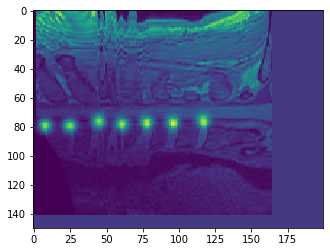

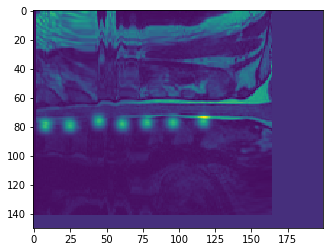

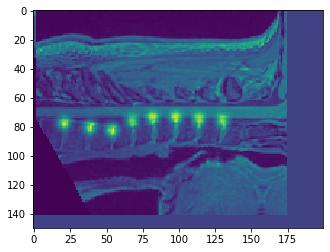

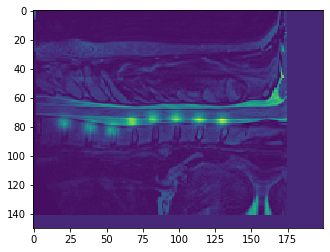

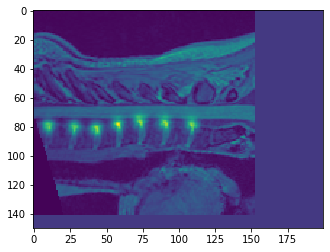

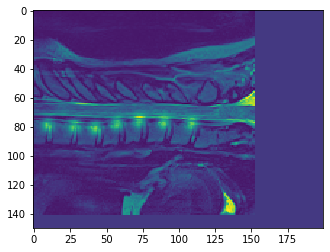

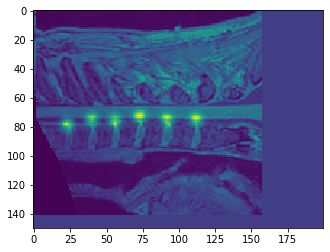

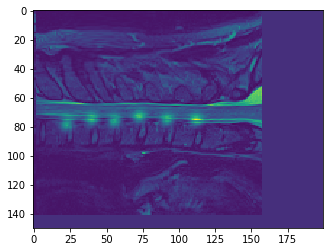

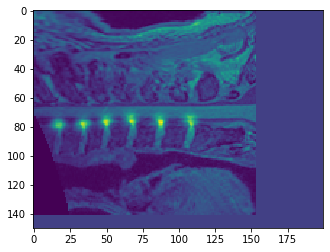

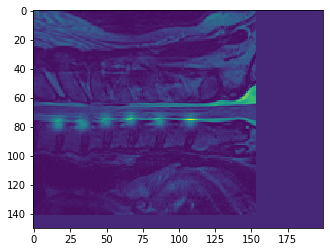

In [756]:
%matplotlib inline
for x in range (30,40):
    plt.imshow(full[0][x][:,:,0]+5*full[1][x][:,:,0])
    plt.show()

In [130]:
ds_2=[ds[0][:10],ds[1][:10]]

In [264]:
full=extract_groundtruth_v2(ds)

(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)


/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:124: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 

(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 200, 1)
(150, 

In [722]:
full[0].shape

(456, 150, 200, 1)

#### loader for patch

In [172]:
gmdataset_train = valdataset(image_paths=patch[0][:150], target_paths=patch[1][:150])
gmdataset_val = valdataset(image_paths=patch[0][150:180], target_paths=patch[1][150:180])

print('lendata'+str(len(gmdataset_train)))
train_loader = DataLoader(gmdataset_train, batch_size=10,
                              shuffle=False,
                              num_workers=0)
val_loader = DataLoader(gmdataset_val, batch_size=10,
                            shuffle=False,
                            num_workers=0)

lendata150


In [168]:
import skimage

In [241]:
full[0].shape

(456, 150, 200, 1)

#### loader for full MRI 

In [770]:
full_dataset_train =valdataset(image_paths=full[0][0:100], target_paths=full[1][:100])
full_dataset_val = valdataset(image_paths=full[0][0:10], target_paths=full[1][0:10])

print('lendata'+str(len(full_dataset_train)))
train_loader = DataLoader(full_dataset_train, batch_size=2,
                              shuffle=False,
                              num_workers=0)
val_loader = DataLoader(full_dataset_val, batch_size=2,
                            shuffle=False,
                            num_workers=0)

lendata100


In [31]:
import copy
from torch.optim.lr_scheduler import StepLR

In [87]:
model = fcn_vl_v3(drop_rate=0.3, bn_momentum=0.1)

In [29]:
model=torch.load('model_l2_spec_np.pt')

In [100]:
num_epochs = 400
initial_lr = 0.00005
val_glob=85
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
model=model.double()
model.cuda()
# import ipdb as pdb; pdb.set_trace()
#writer = SummaryWriter(log_dir='/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/Unet_FPGA_IVADO-master')
for epoch in tqdm(range(1, num_epochs+1)):
    scheduler.step()


    
    #lr = 0.000025
    #writer.add_scalar('learning_rate', lr, epoch)
    model.train()
    train_loss_total = 0.0
    num_steps = 0
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch[0], batch[1]
        
        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda()

       
        
        #var_input = input_samples
        
        #print(var_input)
        #var_gt = gt_samples
        preds = model(var_input)
        #print(preds)
        #var_gt=var_gt
        #print('predssize'+str(preds.view(-1).size()))
        #print('gt_size'+str(var_gt.view(-1).size()))
        predi=preds.data.cpu().numpy()
        
        inpu=var_input.data.cpu().numpy()
        
        gt_s=var_gt.data.cpu().numpy()
        
        
        
        #loss_2=loss_number_of_point(var_gt,preds)
        #loss_2=loss_2.double()
        #loss_2=torch.sum(loss_2)
        #loss_3=loss_l2_disk(var_gt,preds)
       # loss_3=loss_3.double()
        loss_4=dice_loss(var_gt,preds)
        #loss_5=AdapWingLoss(preds, var_gt)
        #loss_3=loss_2(preds,var_gt)
        #print(loss_2)
        #loss=dice_loss(predi,gt_s)
       
        # if epoch == 1 and i == len(train_loader) - 1:
        #     import ipdb as pdb; pdb.set_trace()
        # if epoch == 4 and i == len(train_loader) - 1:
        #     import ipdb as pdb; pdb.set_trace()
     
        #train_loss_total+=loss_2.item()
        #train_loss_total+=loss_3.item()
        #print(train_loss_total)
        #print(train_loss_total)
        #loss_targ=reduce(add, loss_2)
        
        
        #loss_tot=torch.sum(loss_tot)
        #print(loss_tot)
        #loss_tot=loss_tot.double()
        #loss_tot.cuda()

        optimizer.zero_grad()
        #loss.backward(retain_graph=True)
        loss_4.backward()
        #loss_2.backward()
       # loss_3.backward()
        
        #loss_5.backward()
        optimizer.step()
        
        num_steps += 1
        #print(num_steps)
        #train_loss_total += loss_4.item()
        #train_loss_total += loss_5.item()
        train_loss_total_avg = train_loss_total / num_steps

        # import ipdb as pdb; pdb.set_trace()
    model.eval()
    val_loss_total = 0.0
    num_steps = 0

        

        

    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch[0], batch[1]
        

        with torch.no_grad():

            var_input = input_samples.cuda()
            var_gt = gt_samples.cuda()



            preds = model(var_input)

            loss_3=loss_l2_disk(var_gt,preds)
            loss_3=loss_3.double()
            val_loss_total += loss_3.item()
            print(loss_3.item())

        # Metrics computation
        #gt_npy = gt_samples.data.cpu().numpy().astype(np.uint8)
        #gt_npy = gt_npy.squeeze(axis=1)

        #preds = preds.data.cpu().numpy()
       # preds = threshold_predictions(preds)
       # preds = preds.astype(np.uint8)
       # preds = preds.squeeze(axis=1)
   #loss=dice_loss(preds,gt_npy)
   #val_loss_total += loss.item()
       # np.save('result.npy',preds)
       # np.save('gt.npy',gt_npy)
       # input_npy=var_input.data.cpu().numpy()
      #  np.save('input.npy',input_npy)

       # metric_mgr(preds, gt_npy)

        num_steps += 1

   # metrics_dict = metric_mgr.get_results()
   # metric_mgr.reset()

   # writer.add_scalars('metrics', metrics_dict, epoch)

    val_loss_total_avg = val_loss_total / num_steps
    if val_loss_total_avg < val_glob:
        val_glob=copy.deepcopy(val_loss_total_avg)
        best_model = copy.deepcopy(model)
        torch.save(best_model, 'model_l2_further_train.pt')
    full_inp=transforms.ToTensor()(full[0][1][:256,:256])
    full_inp=full_inp.unsqueeze(0)
    full_inp=full_inp.double()
    full_gt=transforms.ToTensor()(full[1][1][:256,:256])
    full_gt=full_gt.double()
    full_gt=full_gt.unsqueeze(0)
    full_pred=model(full_inp.cuda())
    loss_full=loss_l2_disk(full_pred,full_gt.cuda())
    #loss_full.backward()

    print('losses', {'val_loss': val_loss_total_avg,'train_loss': train_loss_total_avg,'on_full_image':loss_full.item(),'dice':loss_4.item(),'wing':loss_5.item()}, epoch)







  0%|          | 0/400 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (60000) must match the size of tensor b (87648) at non-singleton dimension 0

In [507]:
best_model = copy.deepcopy(model)
torch.save(best_model, 'model_patch_straight_drop06.pt')

In [33]:
%matplotlib inline

In [ ]:
b=transforms.ToTensor()(np.expand_dims(normalize(test_4),axis=-1))
b=b.unsqueeze(0)


In [ ]:
test_ds=[[],[]]
for x in hard:

    test_ds[0].append(ds[0][x])
    test_ds[1].append(ds[1][x])

In [62]:
model_2 = copy.deepcopy(model)

In [63]:
model_2.dropout=nn.Dropout2d(p=0.3, inplace=False)

In [ ]:
model=torch.load('model.pt')

In [ ]:
import cv2

In [ ]:
#img_anat = np.dstack((img_anat,img_anat,img_anat))
#img_pred = denormalize2uint8(prediction[0, :,:,0])
overlay=np.add(predi[0,0,:,:]*1,inpu[0,0,:,:]*1)
plt.imshow(overlay[:,:])

In [ ]:
#running test on clip limit
import nibabel as nib 
path_to='/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/flatten_sag.nii'
mri=nib.load(path_to)
testing_im=np.array(mri.dataobj)[64,:,:]
t=[0.2,0.2,0.5]
for i in range (len(t)):
    
    #test_2=np.rot90(testing_im,45,(0,1))
    im_2=images_normalization(testing_im)
    test_3=add_zero_padding(im_2[0], x_val=512, y_val=512)
    print(test_3[0].shape)
    img_test_clahe=skimage.exposure.equalize_adapthist(normalize(test_3[0][:,:,0]), kernel_size=None, clip_limit=t[i])
    im_inp=images_normalization(img_test_clahe)
    print(test_3[0].shape)
    b=transforms.ToTensor()(np.expand_dims(im_inp[0],axis=-1))
    b=b.unsqueeze(0)
    b=b.double()
    k=model(b.cuda())
    img_res=k.data.cpu().numpy()
    plt.imshow(img_test_clahe[:,:])
    plt.show()
    plt.imshow(img_res[0,0,:,:])
    plt.show()

In [31]:
%matplotlib inline

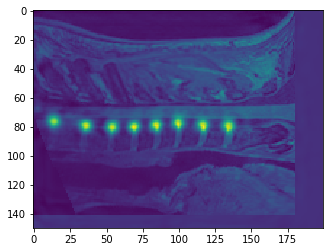

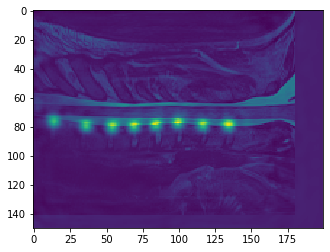

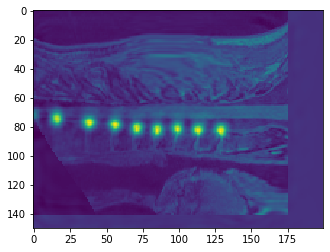

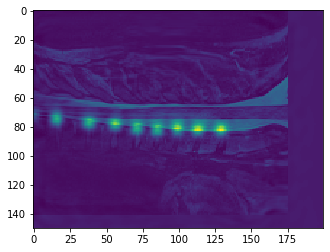

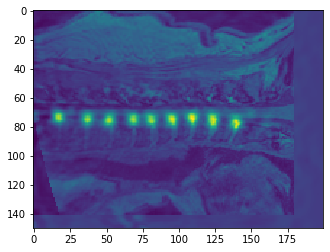

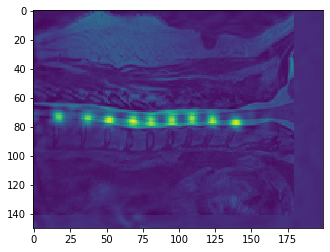

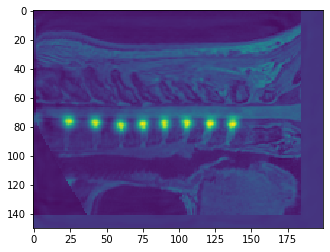

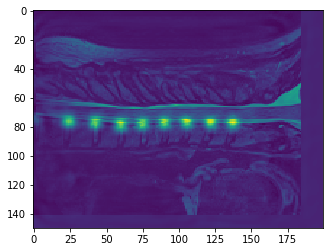

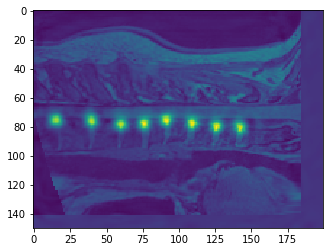

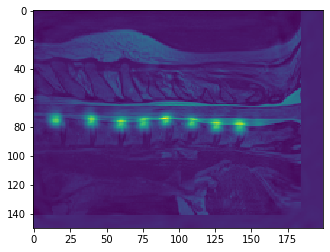

In [777]:
val_loss_total=0
for i, batch in enumerate(val_loader):
            input_samples, gt_samples = batch[0], batch[1]
            

            with torch.no_grad():
                
                var_input = input_samples.cuda()
                var_gt = gt_samples.cuda()
              
                    

                preds = model(var_input)

                loss = caffe_eucl_loss(preds, var_gt)
                val_loss_total += loss.item()
                
                predi=preds.data.cpu().numpy()
                gt_s=var_gt.data.cpu().numpy()
                inpu=var_input.data.cpu().numpy()
                for i in range(len(predi)):
                    overlay0=np.add((predi[0,0,:,:]*10),inpu[i,0,:,:]*1)
                    plt.imshow(overlay0)
                    plt.show()
               # overlay1=np.add(predi[1,0,:,:]*10,inpu[1,0,:,:]*1)
               # plt.imshow(overlay1)
               # plt.show()

            # Metrics computation
            #gt_npy = gt_samples.data.cpu().numpy().astype(np.uint8)
            #gt_npy = gt_npy.squeeze(axis=1)

            #preds = preds.data.cpu().numpy()
           # preds = threshold_predictions(preds)
           # preds = preds.astype(np.uint8)
           # preds = preds.squeeze(axis=1)
	   #loss=dice_loss(preds,gt_npy)
	   #val_loss_total += loss.item()
           # np.save('result.npy',preds)
           # np.save('gt.npy',gt_npy)
           # input_npy=var_input.data.cpu().numpy()
          #  np.save('input.npy',input_npy)

           # metric_mgr(preds, gt_npy)

           

       # metrics_dict = metric_mgr.get_results()
       # metric_mgr.reset()

       # writer.add_scalars('metrics', metrics_dict, epoch)

            #val_loss_total_avg = val_loss_total / num_steps
        
       
        

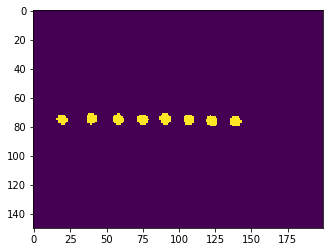

In [753]:
plt.imshow(predi[0,0,:,:]>0.5)

In [410]:
predi.max()

0.9214973245926801

In [ ]:
path_to='/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/flatten_sag.nii'

In [ ]:
testing_im=nib.load(path_to)

In [ ]:
testing_im=np.array(testing_im.dataobj)

In [ ]:
testing_im.shape

In [ ]:
testing_im=testing_im[64,:,:]

In [ ]:
testing_im=np.expand_dims(testing_im,axis=-1)

In [ ]:
testing_im=testing_im*255*255

In [ ]:
testing_im=testing_im.astype('uint16')

In [ ]:
preds[0][0].size()[0]

In [ ]:
index= preds[0][0].argmax()
rows = index / 40
cols = index % 40
print(preds[0][0][rows,cols])

In [ ]:
a=(torch.abs((torch.max(preds[0][0]).item()-preds[0][0]))<0.006).nonzero()

In [ ]:
lis_p=(torch.abs((torch.max(var_gt[0][0]).item()-var_gt[0][0]))<0.006).nonzero()

In [ ]:
var_gt[0][0]

In [ ]:
((torch.max(var_gt[0][0]).item()-var_gt[0][0])<0.004).nonzero()

In [ ]:
var_gt[0][0][100,361]

In [ ]:
def loss_spinal_cord(y_true,y_pred):
    loss=torch.tensor(0)
    for i in range (y_true.size()[0]):
        print(i)
        
        list_true=(torch.abs((torch.max(y_true[i][0]).item()-y_true[i][0]))<0.004).nonzero()
        list_pred=(torch.abs((torch.max(y_pred[i][0]).item()-y_pred[i][0]))<0.004).nonzero()

        if list_true.size()==torch.Size([0, 0]):
            pass
        else:
            #print(list_true)
            x_true=list_true[:,0]
            x_pred=list_pred[:,0]
            print(x_pred)
            diff=(torch.abs((torch.max(x_true).item()-x_pred))>5).nonzero()
            print(diff)
    

In [ ]:
def loss_number_of_point(y_true,y_pred):
    loss_tot=torch.tensor([0.0], requires_grad=True)
    for i in range (y_true.size()[0]):
       # print(i)
        
        list_true=(torch.abs((y_true[i][0]-torch.max(y_true[i][0]).item()))<0.00001).nonzero()
        list_pred=(torch.abs((y_pred[i][0]-torch.max(y_pred[i][0]).item()))<10).nonzero()
        #print(list_true)
        if list_pred.size()[0]<list_true.size()[0]:
            loss=torch.tensor([float(list_true.size()[0]-list_pred.size()[0])],requires_grad=True)
            print(loss.item())
            loss_tot=torch.cat((loss_tot,loss))
        else:
            loss=torch.tensor([1.0],requires_grad=True)
            loss_tot=torch.cat((loss_tot,loss))
    #requires_grad_(requires_grad=True) → loss_tot
    return(loss_tot)

In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(heatmaps.data.cpu()[0,0,:,:])

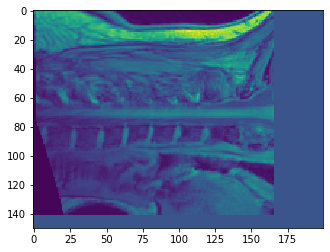

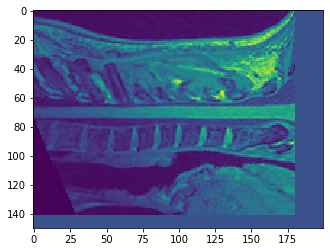

In [769]:
plt.imshow(ds[0][0][:,:,0])
plt.show()
plt.imshow(full[0][0][:,:,0])
plt.show()

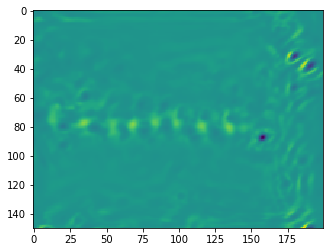

In [775]:
patch=transforms.ToTensor()(full[0][0][:,:,:]).unsqueeze(0).cuda()
patch_out= model(patch)
patch_out=patch_out.data.cpu().numpy()
plt.imshow(patch_out[0,0,:,:])
plt.show()

In [516]:
coord_gt=[]
for i in range (len(ds[1])):
    coord_tmp=[[],[]]
    for j in range(len(ds[1][i])):
        if ds[1][i][j][3]==1 or ds[1][i][j][3]>30:
            pass
        else:
            coord_tmp[0].append(ds[1][i][j][2])
            coord_tmp[1].append(ds[1][i][j][1])
    coord_gt.append(coord_tmp)

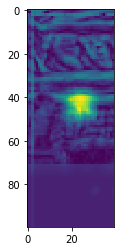

In [34]:
plt.imshow(ds[0][0,:,90:120,0])
patch=skimage.exposure.equalize_adapthist(normalize(ds[0][0,:,90:130,0]), kernel_size=5, clip_limit=0.02)
plt.imshow(patch)
patch_t=np.expand_dims(patch,axis=-1)
patch_t=transforms.ToTensor()(patch_t).unsqueeze(0).cuda()
patch_out= model(patch_t)
patch_out=patch_out.data.cpu().numpy()
plt.imshow(np.add(patch_out[0,0,:,:]*2,patch))

In [ ]:
import numpy as np
from skimage.feature import peak_local_max

In [35]:
 def infer(image,coordinates,curr_heatmap):
        
        final=copy.deepcopy(curr_heatmap)
        #retrieve coordinates of extreme point
        coordinates.sort()
        originx=coordinates[-1][0]
        #originx=6
        originy=15
        sorted(coordinates,key = lambda x: x[0])
        maxdifx=abs(coordinates[0][0]-coordinates[-1][0])
        if maxdifx<45:
            maxdifx=45
        while originy+30< image.shape[0]:
            #print(originy)
            patch=image[originx-15:originx+maxdifx,originy-15:originy+15,0]
            path=normalize(patch)
            patch=skimage.exposure.equalize_adapthist(normalize(patch), kernel_size=10, clip_limit=0.02)
            plt.imshow(patch)
            plt.show()
            patch=np.expand_dims(patch,axis=-1)
            patch=transforms.ToTensor()(patch).unsqueeze(0).cuda()
            patch_out= model(patch)
            patch_out=patch_out.data.cpu().numpy()
            for w in range (maxdifx):
                for h in range(30):
                    final[0,0,w,h]=max(final[0,0,originx+w,originy+h],patch_out[0,0,w,h])
            #final[0,0,originx-5:originx+80,originy-25:originy+50]=patch_out[0,0,:,:]
            originy=originy+20
        return (final)
            
    
    #infer on patches and modify output 
    #retake the coordinates
    #output it
    # Per-location euclidean losses

In [74]:
def load_Data_just_check(im_path):
    size_val = 512
    ds_image=[]
    ds_label=[]
   # list_dir=os.listdir(DataSet_path)
    #list_dir.sort()
   # if '.DS_Store' in list_dir:
       # list_dir.remove('.DS_Store')
   # a=len(list_dir)
   # for i in range (a):
    #path_tmp=DataSet_path
       
    im=nib.load(im_path)
    arr=np.array(im.dataobj)
    slics=int(np.round(arr.shape[0]/2))
    mid_slice=get_midNifti(im_path,slics)
    print(mid_slice.shape)
   # if mid_slice.shape[0]>512:
     #   print('removed')
    #    pass
   # elif mid_slice.shape[1]>512:
   #     print('removed')
  #      pass
  #  else:
    ds_image.append(mid_slice)
           
    
    ds_image = images_normalization(ds_image)
    

    # Zero padding
    #ds_image = add_zero_padding(ds_image, x_val=size_val, y_val=size_val)
    #val_ds_img = add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    #test_ds_img = add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    ds_image = np.array(ds_image)
        
        
    return [ds_image,ds_label] 

In [156]:
mid_check=load_Data_just_check('/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019/PolyDatabase_2/milan_2017-filippi_078/t2/t2_order_r_flatten_straight.nii.gz')

(145, 508)


In [35]:
import SimpleITK as sitk
def N4():
    print("N4 bias correction runs.")
    inputImage = sitk.ReadImage('/home/GRAMES.POLYMTL.CA/luroub/sct_example_data/t2/t2_straight.nii.gz')
    # maskImage = sitk.ReadImage("06-t1c_mask.nii.gz")
    maskImage = sitk.OtsuThreshold(inputImage,0,1,500)
    #sitk.WriteImage(maskImage, "06-t1c_mask3.nii.gz")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    output = corrector.Execute(inputImage,maskImage)
    out=np.array(output.dataobj)
    plt.imshow(out[45,:,:])
    plt.show()
    #sitk.WriteImage(output,"N4_output3.nii.gz")
    print("Finished N4 Bias Field Correction.....")


In [260]:
def infer_straight(image,c=0.02):
        coord_out=[]
        shape_im=image.shape
        
        final=np.zeros((shape_im[0],shape_im[1]))
        middle_test=int(np.round(shape_im[0]*0.2))
        shape_im=sorted(shape_im)
        #retrieve coordinates of extreme point
        #coordinates.sort()
       # originx=coordinates[-1][0]
        #originx=6
        originy=0
        image=normalize(image[:,:,0])
        
        while originy+31< shape_im[2]:
            #print(originy)
            patch=image[:,originy:originy+30]
            patch=normalize(patch)
            
            #patch=skimage.exposure.equalize_adapthist(patch,kernel_size=10,clip_limit=c)
            
            patch=np.expand_dims(patch,axis=-1)
            #patch=Ying_2017_CAIP(patch)
            
            patch=transforms.ToTensor()(patch).unsqueeze(0).cuda()
            patch=patch.double()
            patch_out= model_2(patch)
            patch_out=patch_out.data.cpu().numpy()
           
            coordinates_tmp= peak_local_max(patch_out[0,0,:,:],min_distance=1, threshold_rel=0.9)
            for w in range (patch.shape[0]):
                for h in range(0,30):
                    final[w+35,originy+h]=max(final[w,originy+h],patch_out[0,0,w,h])
            #final[0,0,originx-5:originx+80,originy-25:originy+50]=patch_out[0,0,:,:]
            
            for x in coordinates_tmp:
                x[1]=x[1]+originy
                
                coord_out.append([x[1],x[0]])
            #coord_out.append(coordinates_tmp)
            originy=originy+10
            #print(originy)
        #print(coord_out)
        return (final,coord_out)

In [43]:
import skimage

In [126]:
final,coordinates=infer_straight(ds[0][0])

/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [161]:
shape=(1,145, 508)
final=np.zeros(shape)
for x in coordinates:
    
    train_lbs_tmp_mask=label2MaskMap_2(x,shape)
    for w in range (shape[1]):
                for h in range(shape[2]):
                    final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])

In [41]:
for im in test:
    im=np.expand_dims(im,axis=-1)
    final,coordinates=infer_straight(im,c=0.02)
    final=np.zeros((100,50,1))
    print(full[0][0].shape)
    for x in coordinates:
        print(x)
    
        train_lbs_tmp_mask=label2MaskMap_2(x,(1,100,50))
        for w in range (im.shape[0]):
            for h in range(im.shape[1]):
                final[w,h,0]=max(final[w,h,0],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[:,:,0]*0,im[:,:,0]))
    plt.show()
    

(100, 50)
(100, 300, 1)
[79, 44]
[91, 43]
[92, 44]
[105, 42]


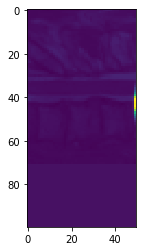

In [70]:
final,coordinates=infer_straight(resultat,c=0.02)
final=np.zeros((100,50,1))
print(full[0][0].shape)
for x in coordinates:
    print(x)
    
    train_lbs_tmp_mask=label2MaskMap_2(x,(1,100,50))
    for w in range (im.shape[0]):
         for h in range(im.shape[1]):
            final[w,h,0]=max(final[w,h,0],train_lbs_tmp_mask[w,h])
plt.imshow(np.add(final[:,:,0]*10,resultat[:,:,0]))
plt.show()

In [514]:
def label2MaskMap_2(data,shape, c_dx = 0, c_dy = 0, radius = 10, normalize = False):
    """
    Generate a Mask map from the coordenates
    :param M, N: dimesion of output
    :param position: position of the label
    :param radius: is the radius of the gaussian function
    :return: a MxN normalized array
    """

    # Our 2-dimensional distribution will be over variables X and Y
    (M,N)=(shape[2],shape[1])
    if len(data)<=2:
        data = [data]

    maskMap = []
    for index, value in enumerate(data):
        x,y = value

        #Correct the labels
        x = x + c_dx
        y = y + c_dy

        X = np.linspace(0, M - 1, M)
        Y = np.linspace(0, N - 1, N)
        X, Y = np.meshgrid(X, Y)
        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y

        # Mean vector and covariance matrix
        mu = np.array([x, y])
        Sigma = np.array([[radius, 0], [0, radius]])

        # The distribution on the variables X, Y packed into pos.
        Z = multivariate_gaussian(pos, mu, Sigma)

        # Normalization
        if normalize:
            Z = Z * (1 / np.max(Z))
        else:
            # 8bit image values (the loss go to inf+)
            Z = Z * (1 / np.max(Z))
            Z = np.asarray(Z * 255, dtype=np.uint8)

        maskMap.append(Z)

    if len(maskMap) == 1:
        maskMap = maskMap[0]

    return np.asarray(maskMap)

In [711]:
distance_l2=[]
zdis=[]
faux_pos=[]
faux_neg=[]
compteur=[]
compteur_tot=[]

In [282]:
zdis_l=[]
distance_l2_l=[]

In [780]:
def infer_cception(image,c=0.02):
        coord_out=[]
        shape_im=image.shape
        
        final=np.zeros((shape_im[0],shape_im[1]))
        
        shape_im=sorted(shape_im)
        #retrieve coordinates of extreme point
        #coordinates.sort()
       # originx=coordinates[-1][0]
        #originx=6
        originy=0
        #image=normalize(image[:,:,0])
        
            #print(originy)
        patch = image[:,:,0]
        #patch = normalize(patch)
        plt.imshow(patch)
        plt.show()
            
        #patch = skimage.exposure.equalize_adapthist(patch,kernel_size=20,clip_limit=0.02)
            
        patch = np.expand_dims(patch,axis=-1)
        #patch=Ying_2017_CAIP(patch)
            
        patch = transforms.ToTensor()(patch).unsqueeze(0).cuda()
        patch = patch.double()
        patch_out = model(patch)
        patch_out = patch_out.data.cpu().numpy()
        plt.imshow(patch_out[0,0,:,:])  
        plt.show()
        coordinates_tmp = peak_local_max(patch_out[0,0,:,:],min_distance=5, threshold_abs=0.5)
        for w in range (patch.shape[0]):
            for h in range(patch.shape[1]):
                final[w,h]=max(final[w,h],patch_out[0,0,w,h])
            #final[0,0,originx-5:originx+80,originy-25:originy+50]=patch_out[0,0,:,:]
            
                
        for x in coordinates_tmp:
            coord_out.append([x[1],x[0]])
            #coord_out.append(coordinates_tmp)
            #print(originy)
        #print(coord_out)
        return (final,coord_out)

In [395]:
def final_function(Image,i):
    shape_im=Image.shape
    shape_im=sorted(shape_im)
    final,coordinates=infer_straight(Image)
    final=np.zeros(shape_im)
    print('before post_proc')
    for x in coordinates:
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        #plt.imshow(train_lbs_tmp_mask)
        #plt.show()
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:]*1,40*Image[:,:,0]))
    plt.show()
    print('after post_proc')
    final=np.zeros(shape_im)
    compteur_tot.append(len(coordinates))
    coord_out,c=post_processing_2(coordinates)
    
    mesure_err_disc(coord_gt[i],coord_out,distance_l2_l)
    mesure_err_z(coord_gt[i],coord_out,zdis_l)
    faux_neg.append(len(coord_gt[i][0])-len(coord_out))
    compteur.append(c)
    for x in coord_out:
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:,]*1,40*Image[:,:,0]))
    plt.show()

In [760]:
def final_function_cception(Image):
    shape_im=Image.shape
    shape_im=sorted(shape_im)
    final,coordinates=infer_cception(Image)
    print(coordinates)
    final=np.zeros(shape_im)
    print('before post_proc')
    for x in coordinates:
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        #plt.imshow(train_lbs_tmp_mask)
        #plt.show()
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:]*1,40*Image[:,:,0]))
    plt.show()
    print('after post_proc')
    final=np.zeros(shape_im)
    coord_out=post_processing(coordinates)
    print('checking_out')
    print(coord_out)
    mesure_err_disc(coord_gt[i],coord_out,distance_l2)
    mesure_err_z(coord_gt[i],coord_out,zdis)
    fp= Faux_pos(coord_gt[i],coord_out)
    fn= Faux_neg(coord_gt[i],coord_out)
    faux_pos.append(fp)
    faux_neg.append(fn)
    for x in coord_out:
        print(coord_out)
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        for w in range (shape_im[1]):
                   for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:,]*1,40*Image[:,:,0]))
    plt.show()

In [72]:
path='/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/straight_t2_post_handseg/'

(59, 365)


/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


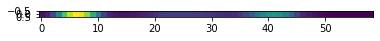

[]
before post_proc


ValueError: operands could not be broadcast together with shapes (59,365) (1,59) 

In [421]:
list_str=os.listdir('/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/straight_t2_post_handseg/')
if '.DS_Store' in list_str:
    list_str.remove('.DS_Store')
    
for x in list_str:
    path_tmp=path+x
    mid_check=load_Data_just_check(path_tmp)
    final_function_cception(mid_check[0][:,:,:])

In [ ]:
%matplotlib inline

0


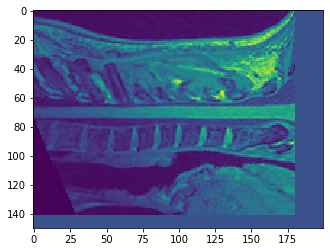

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 15.90 GiB total capacity; 14.83 GiB already allocated; 19.88 MiB free; 322.67 MiB cached)

In [785]:
for i in range(len(coord_gt)):
    print(i)
    #path_tmp=path+x
    #mid_check=load_Data_just_check(path_tmp)
    final_function_cception(full[0][i][:,:,:])
    print(coord_gt[i])
    

In [371]:
import statistics

In [374]:
statistics.median([77, 77, 109, 110, 77, 108, 76, 103, 101, 77, 100, 80, 102, 83, 90])

90

In [344]:
def mesure_err_disc(gt,pred,dis):
    loss=[]
    print(pred)
    for i in range (len(gt[0])):
        node=np.array([gt[0][i],gt[1][i]])
        h=closest_node(node,pred)
        dis.append(np.linalg.norm(node-pred[h]))
        
        

In [345]:
def mesure_err_z(gt,pred,z):
    loss=[]
    
    for i in range (len(gt[0])):
        node=np.array([gt[0][i],gt[1][i]])
        h=closest_node(node,pred)
        z.append(abs(node[0]-pred[h][0]))
   

In [342]:
def closest_node(node, nodes):
    
    nodes1 = np.asarray(nodes)
    print(nodes)
    dist_2 = np.sum((nodes1 - node)**2, axis=1)
    return np.argmin(dist_2)

In [678]:
tot=[]

In [682]:
def Faux_pos(gt,pred):
    c=0
    
    gt=np.transpose(gt)
    tot.append(len(gt))
    already_used=[]
    for i in range (len(pred)):
        
        node=np.array([pred[i][0],pred[i][1]])
        h=closest_node(node,gt)
        if (abs(node[1]-gt[h][1]))>10 :
            print('fauxP')
            c=c+1
        elif h in already_used:
            c=c+1
    return c


In [707]:
def Faux_neg(gt,pred):
    c=0
    gt=np.transpose(gt)
    for i in range (len(gt[0])):
        node=np.array([gt[0][i],gt[1][i]])
        h=closest_node(node,pred)
        if (abs(node[0]-pred[h][0]))>5 :
            c=c+1
    return c


In [786]:
4.12*395

1627.4

In [717]:
print (np.median(distance_l2))
print(np.std(distance_l2))
print(np.mean(zdis))
print(np.std(zdis))
print(faux_neg)
print(np.sum(tot[-50:]))
print(np.sum(faux_neg))
print(np.sum(faux_pos))

1.7071067811865475
3.124079337023382
1.615979381443299
3.016185260448713
[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
388
16
2


In [715]:
np.sum(faux_neg)

16

In [716]:
print(np.percentile(zdis,95)) 

4.0


In [718]:
16/388

0.041237113402061855

Nouveau post-processing :
print (np.median(distance_l2))     1.4142135623730951
print(np.std(distance_l2))         6.3432112009730055
print(np.median(zdis))             1.0
print(np.std(zdis))                5.9082233420758135
print(np.percentile(zdis,90))      2


Ancien post-processing :


In [295]:
np.percentile(distance_l2,90)

4.123105625617661

In [54]:
pred=[[6, 40], [29.0, 43.0], [49.0, 44.0], [69.0, 44.0], [83.0, 44.0], [100.0, 42.0], [118.0, 41.0], [135.0, 43.0], [156, 44], [157, 44]]
gt=[[150, 132, 115, 100, 83, 71, 54, 36], [44, 41, 41, 39, 42, 41, 41, 40]]

In [54]:
def post_processing(coordinates):
    c=0
    coordinates_tmp=[]
    print(coordinates)
    coordinates=sorted(coordinates,key= lambda x :x[0])
    width_pos=[x[1] for x in coordinates]
    height_pos=[x[0] for x in coordinates]
    
    mean=np.median(width_pos)
    to_remove=[]
    for i in range (len(width_pos)) :
        if abs(width_pos[i]-mean)>15:
            to_remove.append(i)
    for i in range (len(coordinates)):
        if i in to_remove:
            pass
        else:
            coordinates_tmp.append(coordinates[i])
    
    width_pos_c=[x[1] for x in coordinates_tmp]
    height_pos_c=[x[0] for x in coordinates_tmp]
    new_height=[]
    new_width=[]
    i=0
    while i < len(height_pos_c) :
        j=i
        tmp=[]
      
        while j<len(height_pos_c)-2 and abs(height_pos_c[j]-height_pos_c[j+1])<10 :
            if len(tmp)>0: 
                if abs(height_pos_c[tmp[0]]-height_pos_c[j+1])>20:
                    print('toomuch')
                    break
                else :
                    print(height_pos_c[tmp[0]]-height_pos_c[j+1])
            tmp.append(j)
            j=j+1
            print(tmp)
            
            
        
        if len(tmp)>0:
            
            h=np.round(np.mean(height_pos_c[tmp[0]:tmp[len(tmp)-1]+1]))
            w=np.round(np.mean(width_pos_c[tmp[0]:tmp[len(tmp)-1]+1]))
   
            new_height.append(h)
            new_width.append(w)
            i=i+len(tmp)+1
            
        else:
            h=height_pos_c[i]
            w=width_pos_c[i]
         
            new_height.append(h)
            new_width.append(w)
            i=i+1
    coordinates_tmp=[]        
    for a in range (len(new_height)):
        coordinates_tmp.append([new_height[a],new_width[a]])
    coordinates=sorted(coordinates_tmp,key= lambda x :x[0])    
    width_pos_c=[x[1] for x in coordinates_tmp]
    height_pos_c=[x[0] for x in coordinates_tmp]
    distance=[]
    coord_out=[]
    
    
    
    
    to_remove=[]
    for i in range (len(height_pos_c)-1):
        distance.append(height_pos_c[i+1]-height_pos_c[i])
    dis_mean_g=np.mean(distance)
    #print(dis_mean)
    for i in range (1,len(height_pos_c)-1):
        dis_mean=dis_mean_g
    
        print(height_pos_c[i+1]-height_pos_c[i])
        if i <len(height_pos_c)-4:
            distance_2=[]
            for j in range (4):
                distance_2.append(height_pos_c[i+j]-height_pos_c[i+j-1])
                dis_mean=np.median(distance_2)
            print(dis_mean)
        #if abs(abs((height_pos_c[i+1]-height_pos_c[i]))-abs((height_pos_c[i]-height_pos_c[i-1])))>10 and abs(abs((height_pos_c[i+1]-height_pos_c[i]))-abs((height_pos_c[i]-height_pos_c[i-1])))<35:
        if abs(height_pos_c[i]-height_pos_c[i-1])<dis_mean-0.1*dis_mean:
            if abs(height_pos_c[i+1]-height_pos_c[i])<dis_mean-0.7*dis_mean  :
                to_remove.append(i)
                print(coordinates_tmp[i])
                print('dif dis')
                print(abs(abs((height_pos_c[i+1]-height_pos_c[i]))-abs((height_pos_c[i]-height_pos_c[i-1]))))
    for i in range (len(coordinates_tmp)):
        if i in to_remove:
            pass
        else:
            coord_out.append(coordinates_tmp[i])
    
    
    
    
    return(coord_out)
    
     
        

In [377]:


def post_processing_2(coordinates):
    c=0
    print(coordinates)
    coordinates_tmp=[]
     #print(coordinates)
    coordinates=sorted(coordinates,key= lambda x :x[0])        # 
    width_pos=[x[1] for x in coordinates]                      # met 

    height_pos=[x[0] for x in coordinates]                     # met 


  
     # enlève les coordonnées qui sont éloignées de plus de 6 de la médiane dans la direction width_pos (x[1])
    if len(width_pos)%2==0:
        width_pos_2=width_pos
        width_pos_2.append(width_pos[0])
    else:
        width_pos_2=width_pos
    mean=np.median(width_pos_2)
    print(mean)# calcule la médiane de width_pos
    to_remove=[]
    for i in range (len(width_pos)) :
         if abs(width_pos[i]-mean)>7:                           # si une coordonnée est éloignée de plus de 6 de la moyenne:
             ### changé seuil de 10 à 6 selon stats (distance entre chaque vertèbre et la moelle, voir graphes juste en haut)
             to_remove.append(i)                                # ajouter l'indice de cette coordonnée dans to_remove
    for i in range (len(coordinates)):
        if i in to_remove:
                c=c+1
                pass
        else:
             coordinates_tmp.append(coordinates[i])             # ajoute dans coordinates_tmp toutes les coordonnées dont l'indice n'est pas dans to_remove

     # =====
    print(coordinates_tmp)

    width_pos_c=[x[1] for x in coordinates_tmp]                # met 

    height_pos_c=[x[0] for x in coordinates_tmp]               # met 

    new_height=[]
    new_width=[]
    i=0
    while i < len(height_pos_c) :
        j=i
        tmp=[]

        while j<len(height_pos_c)-2 and abs(height_pos_c[j]-height_pos_c[j+1])<10 :
            if len(tmp)>0: 
                if abs(height_pos_c[tmp[0]]-height_pos_c[j+1])>20:
                    print('toomuch')
                    break
                else :
                    print(height_pos_c[tmp[0]]-height_pos_c[j+1])
            tmp.append(j)
            j=j+1
            c=c+1
     
            
             #print(tmp)
        if len(tmp)>0:
            
            h=np.round(np.mean(height_pos_c[tmp[0]:tmp[len(tmp)-1]+1]))
            w=np.round(np.mean(width_pos_c[tmp[0]:tmp[len(tmp)-1]+1]))
   
            new_height.append(h)
            new_width.append(w)
            i=i+len(tmp)+1
            
        else:
            h=height_pos_c[i]
            w=width_pos_c[i]
         
            new_height.append(h)
            new_width.append(w)
            i=i+1
    coordinates_tmp=[]        
    for a in range (len(new_height)):
        coordinates_tmp.append([new_height[a],new_width[a]])
    coordinates=sorted(coordinates_tmp,key= lambda x :x[0]) 
    print(coordinates)
    width_pos_c=[x[1] for x in coordinates_tmp]
    height_pos_c=[x[0] for x in coordinates_tmp]
    
     # but de cette partie du code : enlever les points qui sont entre 

    to_keep = []
    distance = []
    coord_out = []


     #premiere distance
    indice_initial = 0
    while len(distance) != 1: 
            if indice_initial+2 < len(height_pos_c)-1:
                # cette boucle roule tant qu'un premier point 

                distance_0_1 = height_pos_c[indice_initial+1]-height_pos[indice_initial]        # 

                distance_1_2 = height_pos_c[indice_initial+2]-height_pos[indice_initial+1]
                if distance_0_1 > 13 and distance_1_2 > 13:                   
                   # une fois que le critère est respecté (les 

                    to_keep.append(indice_initial)                             
                   # place dans to_keep la coordonnée du point à 

                    to_keep.append(indice_initial+1)
                    distance.append(distance_0_1)
                else:
                    indice_initial = indice_initial + 1
                    c=c+1
                   # si le critère n'est pas respecté, regarder le 
            else:
                return(coordinates_tmp,c)
                   

     #distances suivantes
            
    print(distance)
    for i in range (indice_initial, len(height_pos_c)-3): # 
        
        seuil = distance[i-indice_initial]-round(0.3*distance[i-indice_initial])       
  # enlever 20% à la distance d'avant pour en faire le seuil
        if seuil > 20:
            seuil=15
            print(i)
            to_keep.append(i+2)
            distance.append(15)
        elif abs(height_pos_c[i+3]-height_pos_c[i+2]) >= seuil or abs(height_pos_c[i+2]-height_pos_c[i+1] >= seuil):
            
            print(height_pos_c[i+3]-height_pos_c[i+2])
            to_keep.append(i+2)
            distance.append(height_pos_c[i+2]-height_pos_c[i+1])
        else :
             distance.append(15)


    to_keep.append(len(height_pos_c)-1)

     # mettre dans coord_out toutes les coordonnées des points à conserver
    for j in range(len(height_pos_c)):
        if j in to_keep:
            coord_out.append(coordinates_tmp[j])
        else:
            c=c+1
    coord_out = sorted(coord_out, key=lambda x:x[0])





    return(coord_out,c)


In [40]:
def final_function_2(Image):
    shape_im=Image.shape
    shape_im=sorted(shape_im)
    final,coordinates=infer_straight(Image)
    final=np.zeros(shape_im)
    print('before post_proc')
    for x in coordinates:
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        #plt.imshow(train_lbs_tmp_mask)
        #plt.show()
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:]*1,30*Image[:,:,0]))
    plt.show()
    print('after post_proc')
    final=np.zeros(shape_im)
    coord_out=post_processing(coordinates)
    for x in coord_out:
    
        train_lbs_tmp_mask=label2MaskMap_2(x,shape_im)
        #plt.imshow(train_lbs_tmp_mask)
        #plt.show()
        for w in range (shape_im[1]):
                    for h in range(shape_im[2]):
                        final[0,w,h]=max(final[0,w,h],train_lbs_tmp_mask[w,h])
    plt.imshow(np.add(final[0,:,:,]*1,30*Image[:,:,0]))
    
    plt.show()
    return(coord_out)

In [166]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
import imageio
import scipy, scipy.misc, scipy.signal


import sys

def computeTextureWeights(fin, sigma, sharpness):
    dt0_v = np.vstack((np.diff(fin, n=1, axis=0), fin[0,:]-fin[-1,:]))
    dt0_h = np.vstack((np.diff(fin, n=1, axis=1).conj().T, fin[:,0].conj().T-fin[:,-1].conj().T)).conj().T

    gauker_h = scipy.signal.convolve2d(dt0_h, np.ones((1,sigma)), mode='same')
    gauker_v = scipy.signal.convolve2d(dt0_v, np.ones((sigma,1)), mode='same')

    W_h = 1/(np.abs(gauker_h)*np.abs(dt0_h)+sharpness)
    W_v = 1/(np.abs(gauker_v)*np.abs(dt0_v)+sharpness)

    return  W_h, W_v
    
def solveLinearEquation(IN, wx, wy, lamda):
    [r, c] = IN.shape
    k = r * c
    dx =  -lamda * wx.flatten('F')
    dy =  -lamda * wy.flatten('F')
    tempx = np.roll(wx, 1, axis=1)
    tempy = np.roll(wy, 1, axis=0)
    dxa = -lamda *tempx.flatten('F')
    dya = -lamda *tempy.flatten('F')
    tmp = wx[:,-1]
    tempx = np.concatenate((tmp[:,None], np.zeros((r,c-1))), axis=1)
    tmp = wy[-1,:]
    tempy = np.concatenate((tmp[None,:], np.zeros((r-1,c))), axis=0)
    dxd1 = -lamda * tempx.flatten('F')
    dyd1 = -lamda * tempy.flatten('F')
    
    wx[:,-1] = 0
    wy[-1,:] = 0
    dxd2 = -lamda * wx.flatten('F')
    dyd2 = -lamda * wy.flatten('F')
    
    Ax = scipy.sparse.spdiags(np.concatenate((dxd1[:,None], dxd2[:,None]), axis=1).T, np.array([-k+r,-r]), k, k)
    Ay = scipy.sparse.spdiags(np.concatenate((dyd1[None,:], dyd2[None,:]), axis=0), np.array([-r+1,-1]), k, k)
    D = 1 - ( dx + dy + dxa + dya)
    A = ((Ax+Ay) + (Ax+Ay).conj().T + scipy.sparse.spdiags(D, 0, k, k)).T
    
    tin = IN[:,:]
    tout = scipy.sparse.linalg.spsolve(A, tin.flatten('F'))
    OUT = np.reshape(tout, (r, c), order='F')
    
    return OUT
    

def tsmooth(img, lamda=0.01, sigma=3.0, sharpness=0.001):
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    x = np.copy(I)
    wx, wy = computeTextureWeights(x, sigma, sharpness)
    S = solveLinearEquation(I, wx, wy, lamda)
    return S

def rgb2gm(I):
    
    if (I.shape[2] == 3):
        I = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        I = np.abs((I[:,:,0]*I[:,:,1]*I[:,:,2]))**(1/3)

    return I

def applyK(I, k, a=-0.3293, b=1.1258):
    f = lambda x: np.exp((1-x**a)*b)
    beta = f(k)
    gamma = k**a
    J = (I**gamma)*beta
    return J

def entropy(X):
    tmp = X * 255
    tmp[tmp > 255] = 255
    tmp[tmp<0] = 0
    tmp = tmp.astype(np.uint8)
    _, counts = np.unique(tmp, return_counts=True)
    pk = np.asarray(counts)
    pk = 1.0*pk / np.sum(pk, axis=0)
    S = -np.sum(pk * np.log2(pk), axis=0)
    return S

def maxEntropyEnhance(I, isBad, a=-0.3293, b=1.1258):
    # Esatimate k
    tmp = cv2.resize(I, (50,50), interpolation=cv2.INTER_AREA)
    tmp[tmp<0] = 0
    tmp = tmp.real
    tmp=np.expand_dims(tmp,axis=-1)
    Y = rgb2gm(tmp)
    
    isBad = isBad * 1
    isBad = scipy.misc.imresize(isBad, (50,50), interp='bicubic', mode='F')
    isBad[isBad<0.5] = 0
    isBad[isBad>=0.5] = 1
    Y = Y[isBad==1]
    
    if Y.size == 0:
       J = I
       return J
    
    f = lambda k: -entropy(applyK(Y, k))
    opt_k = scipy.optimize.fminbound(f, 1, 7)
    
    # Apply k
    J = applyK(I, opt_k, a, b) - 0.01
    return J
    

def Ying_2017_CAIP(img, mu=0.5, a=-0.3293, b=1.1258):
    lamda = 0.5
    sigma = 5
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    I=np.expand_dims(I,axis=-1)
    print(I.shape)

    # Weight matrix estimation
    t_b = np.max(I, axis=2)
    t_our = cv2.resize(tsmooth(scipy.misc.imresize(t_b, 0.5, interp='bicubic', mode='F'), lamda, sigma), (t_b.shape[1], t_b.shape[0]), interpolation=cv2.INTER_AREA)
    
    # Apply camera model with k(exposure ratio)
    isBad = t_our < 0.5
    J = maxEntropyEnhance(I, isBad)

    # W: Weight Matrix
    t = np.zeros((t_our.shape[0], t_our.shape[1], I.shape[2]))
    for i in range(I.shape[2]):
        t[:,:,i] = t_our
    W = t**mu

    I2 = I*W
    J2 = J*(1-W)

    result = I2 + J2
    result = result * 255
    result[result > 255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

CLAHE


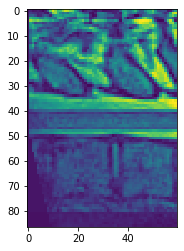

HE


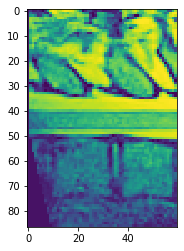

CAIP


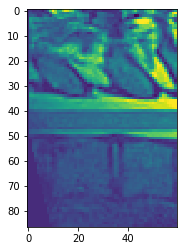

original


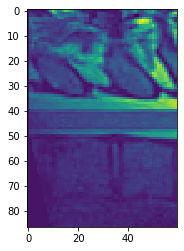

N4


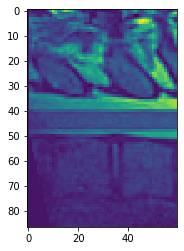

In [134]:
print('CLAHE')
patch=skimage.exposure.equalize_adapthist(normalize(test[:,:60,0]),kernel_size=10,clip_limit=0.02)
plt.imshow(patch)
plt.show()
print('HE')
patch_4=skimage.exposure.equalize_hist(normalize(test[:,:60,0]))
plt.imshow(patch_4)
plt.show()
print('CAIP')
plt.imshow(normalize(resultat[:,:,0]))
plt.show()
print('original')
plt.imshow(normalize(test[:,:60,0]))
plt.show()
print('N4')

plt.imshow(normalize(n4[0][0,:,:60]))
plt.show()

In [125]:
n4=load_Data_just_check('N4_output3.nii.gz')

(87, 241)


### Model number 2 
After the meeting with the MILA, joseph paul cohen gave information about a method that infer on smaller part of each image with reuse of the already computed part. The model is described in th redundant counting article. The idea in this article is to avoid missing cell by trying to spot them multiple time. This is the same kind of problem that we wer trying to counter with the over sampling previously. The application model is below. The v2 is a modified version using bigger inception tree with bigger kernel and max pooling layer closer to what was designed before. It seems to yield good result after patches training on the polydatabse_2 given by Francesco. The patches training is bigger and avoid overfitting. If you train on full images you need to have a definit number of marked points on each ground truth (for now) therefore the model is learning that each image dos not need to be labeled entirely. On the patches all dis are labeled helping with that problem. <br> 
<br> 
The problem encounter become one of local contrast. Eventhough CAIP works well on patches in this not really improving the full image therfore not really useful in this case. Clahe seems to offer some kind of a solution for now. N4 will be put to the test afterward
<br> 
The use of a fully convolutionnal network can be good as well. It might need to use binary label intsaed of gaussin ones. maybe it is possible to combine both technologie by altering the rest of the forward (instead of mulriple inception network a bigger FCN-8 ou FCN 16 ) 
<br>

In [188]:

""" Counception Model
A Pytorch implementation of Count-ception
Inspired by: https://arxiv.org/abs/1703.08710
"""
import torch
import torch.nn as nn
import torch.nn.init as init


class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, ksize=3, stride=1, pad=0, activation=nn.LeakyReLU()):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=ksize, stride=stride, padding=pad)
        self.activation = activation
        self.batch_norm = nn.BatchNorm2d(out_chan)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv1(x)))


class SimpleBlock(nn.Module):
    def __init__(self, in_chan, out_chan_1x1, out_chan_3x3, activation=nn.LeakyReLU()):
        super(SimpleBlock, self).__init__()
        self.conv1 = ConvBlock(in_chan, out_chan_1x1, ksize=1, pad=0, activation=activation)
        self.conv2 = ConvBlock(in_chan, out_chan_3x3, ksize=3, pad=1, activation=activation)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(x)
        output = torch.cat([conv1_out, conv2_out], 1)
        return output
class ModelCountception(nn.Module):
    def __init__(self, inplanes=3, outplanes=1, use_logits=False, logits_per_output=12, debug=False):
        super(ModelCountception, self).__init__()
        # params
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.activation = nn.LeakyReLU(0.01)
        self.final_activation = nn.LeakyReLU(0.01)
        self.patch_size = 32
        self.use_logits = use_logits
        self.logits_per_output = logits_per_output
        self.debug = debug

        torch.LongTensor()

        self.conv1 = ConvBlock(self.inplanes, 64, ksize=5, pad=self.patch_size, activation=self.activation)
        self.simple1 = SimpleBlock(64, 16, 16, activation=self.activation)
        self.simple2 = SimpleBlock(32, 16, 32, activation=self.activation)
        self.conv2 = ConvBlock(48, 16, ksize=14, activation=self.activation)
        self.simple3 = SimpleBlock(16, 112, 48, activation=self.activation)
        self.simple4 = SimpleBlock(160, 64, 32, activation=self.activation)
        self.simple5 = SimpleBlock(96, 40, 40, activation=self.activation)
        self.simple6 = SimpleBlock(80, 32, 96, activation=self.activation)
        self.conv3 = ConvBlock(128, 32, ksize=25, activation=self.activation)
        self.conv4 = ConvBlock(32, 64, ksize=15, activation=self.activation)
        self.conv5 = ConvBlock(64, 64, ksize=10, activation=self.activation)
        if use_logits:
            self.conv6 = nn.ModuleList([ConvBlock(
                64, logits_per_output, ksize=1, activation=self.final_activation) for _ in range(outplanes)])
        else:
            self.conv6 = ConvBlock(64, self.outplanes, ksize=1,activation=self.final_activation)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform(m.weight, gain=init.calculate_gain('leaky_relu', param=0.01))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()




    def _print(self, x):
        if self.debug:
            print(x.size())

    def forward(self, x):
        net = self.conv1(x)  # 32
        self._print(net)
     
        net = self.simple1(net)
      
        self._print(net)
        net = self.simple2(net)
       
        self._print(net)
       
        net = self.conv2(net)
        self._print(net)
        net = self.simple3(net)
        self._print(net)
        net = self.simple4(net)
        self._print(net)
        net = self.simple5(net)
        self._print(net)
        net = self.simple6(net)
        self._print(net)
        net = self.conv3(net)
        self._print(net)
        net = self.conv4(net)
        self._print(net)
        net = self.conv5(net)
        
        self._print(net)
        
        if self.use_logits:
            net = [c(net) for c in self.conv6]
            [self._print(n) for n in net]
        else:
            net = self.conv6(net)
          
            self._print(net)
        return net

    def name(self):
        return 'countception'

In [725]:
model= ModelCountception_v2(inplanes=1,outplanes=1)

/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [726]:
model= model.cuda()
model = model.double()

In [35]:
%matplotlib inline

In [784]:
criterion = loss_l1
solver = optim.Adam(model.parameters(), lr=0.00005)
loss_fcd=FocalDiceLoss()


for epoch in range(1000):
    for idx, (input, target) in enumerate(train_loader):
        input = input.cuda()
        target = target.cuda()
        output = model.forward(input)
        heat=output.data.cpu().numpy()
        #plt.imshow(heat[0,0,:,:])
        #plt.show()
        loss = criterion(output, target)
        loss_focal=AdapWingLoss(output, target)
        #loss_2=dice_loss(output, target)
        

            # Zero grad
        model.zero_grad()
        loss.backward(retain_graph=True)
        loss_focal.backward(retain_graph=True)
        #loss_2.backward()
        solver.step()
        
    #print(loss_l2_disk(output, target))
    with torch.no_grad():
        print('val_mode')
        val_loss = []
        for idx, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()
            output = model.forward(input)
            if (epoch+1) % 1 == 0:
                heat=output.data.cpu().numpy()
                plt.imshow(heat[0,0,:,:]>0.5)
                plt.show()
            val_loss.append(criterion(output, target).item())
           
        print("Epoch", epoch, "- Validation Loss:", np.mean(val_loss))

    if (epoch+1) % 100 == 0:
        state = {'model_weights': model.state_dict()}
        torch.save(state, "checkpoints/radius_10_l1_loss_fromcceptionv2mod.model".format(epoch))


RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 15.90 GiB total capacity; 14.76 GiB already allocated; 51.88 MiB free; 353.75 MiB cached)

In [743]:
state = {'model_weights': model.state_dict()}
torch.save(state, "checkpoints/model_k20l1_loss_finished.model".format(epoch))

In [267]:
model.load_state_dict(torch.load("checkpoints/model_work_clahe_cceptionv2.model")['model_weights'])

<All keys matched successfully>

In [438]:
model_2=model.double()

In [436]:
from torchsummary import summary
summary(model, input_size=(1, 40,40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 118, 118]             640
       BatchNorm2d-2         [-1, 64, 118, 118]             128
         LeakyReLU-3         [-1, 64, 118, 118]               0
         LeakyReLU-4         [-1, 64, 118, 118]               0
         LeakyReLU-5         [-1, 64, 118, 118]               0
         LeakyReLU-6         [-1, 64, 118, 118]               0
         LeakyReLU-7         [-1, 64, 118, 118]               0
         LeakyReLU-8         [-1, 64, 118, 118]               0
         LeakyReLU-9         [-1, 64, 118, 118]               0
        LeakyReLU-10         [-1, 64, 118, 118]               0
        LeakyReLU-11         [-1, 64, 118, 118]               0
        LeakyReLU-12         [-1, 64, 118, 118]               0
        LeakyReLU-13         [-1, 64, 118, 118]               0
        LeakyReLU-14         [-1, 64, 1

In [40]:
torch.cuda.empty_cache()

In [ ]:
%matplotlib inline

In [56]:
from skimage.feature import peak_local_max

In [ ]:
""" Counception Model
A Pytorch implementation of Count-ception
Inspired by: https://arxiv.org/abs/1703.08710
modifed from github https://github.com/roggirg/count-ception_mbm/blob/master/train.py
"""
import torch
import torch.nn as nn
import torch.nn.init as init


class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, ksize=3, stride=1, pad=0, activation=nn.LeakyReLU()):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=ksize, stride=stride, padding=pad)
        self.activation = activation
        self.batch_norm = nn.BatchNorm2d(out_chan)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv1(x)))


class SimpleBlock(nn.Module):
    def __init__(self, in_chan, out_chan_1x1, out_chan_3x3, activation=nn.LeakyReLU()):
        super(SimpleBlock, self).__init__()
        self.conv1 = ConvBlock(in_chan, out_chan_1x1, ksize=3, pad=0, activation=activation)
        self.conv2 = ConvBlock(in_chan, out_chan_3x3, ksize=5, pad=1, activation=activation)
        self.conv3 = ConvBlock(in_chan, out_chan_3x3, ksize=9, pad=3, activation=activation)
        self.MP = nn.MaxPool2d(1)

    def forward(self, x):
        #print('ok')
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(x)
        conv3_out = self.conv3(x)
        #print(conv1_out.size())
        #print(conv2_out.size())
        #print(conv3_out.size())
        output = torch.cat([conv1_out, conv2_out,conv3_out], 1)
        output = self.MP(output)
        return output


class ModelCountception_v2(nn.Module):
    def __init__(self, inplanes=3, outplanes=1, use_logits=False, logits_per_output=12, debug=False):
        super(ModelCountception_v2, self).__init__()
        # params
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.activation = nn.LeakyReLU(0.01)
        self.final_activation = nn.LeakyReLU(0.3)
        self.patch_size = 40
        self.use_logits = use_logits
        self.logits_per_output = logits_per_output
        self.debug = debug

        torch.LongTensor()

        self.conv1 = ConvBlock(self.inplanes, 64, ksize=3, pad=self.patch_size, activation=self.activation)
        self.simple1 = SimpleBlock(64, 16, 16, activation=self.activation)
        self.simple2 = SimpleBlock(48, 16, 32, activation=self.activation)
        self.conv2 = ConvBlock(80, 16, ksize=14, activation=self.activation)
        self.simple3 = SimpleBlock(16, 112, 48, activation=self.activation)
        self.simple4 = SimpleBlock(208, 64, 32, activation=self.activation)
        self.simple5 = SimpleBlock(128, 40, 40, activation=self.activation)
        self.simple6 = SimpleBlock(120, 32, 96, activation=self.activation)
        self.conv3 = ConvBlock(224, 32, ksize=20, activation=self.activation)
        self.conv4 = ConvBlock(32, 64, ksize=10, activation=self.activation)
        self.conv5 = ConvBlock(64, 32, ksize=9, activation=self.activation)
        if use_logits:
            self.conv6 = nn.ModuleList([ConvBlock(
                64, logits_per_output, ksize=1, activation=self.final_activation) for _ in range(outplanes)])
        else:
            self.conv6 = ConvBlock(32, self.outplanes, ksize=20,pad=1,activation=self.final_activation)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform(m.weight, gain=init.calculate_gain('leaky_relu', param=0.01))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _print(self, x):
        if self.debug:
            print(x.size())

    def forward(self, x):
        net = self.conv1(x)  # 32
        self._print(net)
        
     
        net = self.simple1(net)
      
        #self._print(net)
        net = self.simple2(net)
       
        self._print(net)
       
        net = self.conv2(net)
        self._print(net)
        net = self.simple3(net)
        self._print(net)
        net = self.simple4(net)
        self._print(net)
        net = self.simple5(net)
        self._print(net)
        net = self.simple6(net)
        self._print(net)
        net = self.conv3(net)
        self._print(net)
        net = self.conv4(net)
        self._print(net)
        net = self.conv5(net)
        
        self._print(net)
        
        if self.use_logits:
            net = [c(net) for c in self.conv6]
            [self._print(n) for n in net]
        else:
            net = self.conv6(net)
          
            self._print(net)
        return net

    def name(self):
        return 'countception'

In [93]:

import os.path as osp

#import fcn
import torch.nn as nn

#from .fcn32s import get_upsampling_weight

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN8s(nn.Module):


    def __init__(self, n_class=2):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
            else :
                pass

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h

In [152]:
class FCN16s(nn.Module):

  

    def __init__(self, n_class=2):
        super(FCN16s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore16 = nn.ConvTranspose2d(
            n_class, n_class, 32, stride=16, bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c

        h = self.upscore16(h)
        h = h[:, :, 27:27 + x.size()[2], 27:27 + x.size()[3]].contiguous()

        return h

safe keep
class ModelCountception(nn.Module):
    def __init__(self, inplanes=3, outplanes=1, use_logits=False, logits_per_output=12, debug=False):
        super(ModelCountception, self).__init__()
        # params
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.activation = nn.LeakyReLU(0.01)
        self.final_activation = nn.LeakyReLU(0.01)
        self.patch_size = 20
        self.use_logits = use_logits
        self.logits_per_output = logits_per_output
        self.debug = debug

        torch.LongTensor()

        self.conv1 = ConvBlock(self.inplanes, 64, ksize=3, pad=self.patch_size, activation=self.activation)
        self.simple1 = SimpleBlock(64, 16, 16, activation=self.activation)
        self.simple2 = SimpleBlock(32, 16, 32, activation=self.activation)
        self.conv2 = ConvBlock(48, 16, ksize=14, activation=self.activation)
        self.simple3 = SimpleBlock(16, 112, 48, activation=self.activation)
        self.simple4 = SimpleBlock(160, 64, 32, activation=self.activation)
        self.simple5 = SimpleBlock(96, 40, 40, activation=self.activation)
        self.simple6 = SimpleBlock(80, 32, 96, activation=self.activation)
        self.conv3 = ConvBlock(128, 32, ksize=18, activation=self.activation)
        self.conv4 = ConvBlock(32, 64, ksize=1, activation=self.activation)
        self.conv5 = ConvBlock(64, 64, ksize=1, activation=self.activation)
        if use_logits:
            self.conv6 = nn.ModuleList([ConvBlock(
                64, logits_per_output, ksize=1, activation=self.final_activation) for _ in range(outplanes)])
        else:
            self.conv6 = ConvBlock(64, self.outplanes, ksize=11,pad=1,activation=self.final_activation)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform(m.weight, gain=init.calculate_gain('leaky_relu', param=0.01))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()